# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 9  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

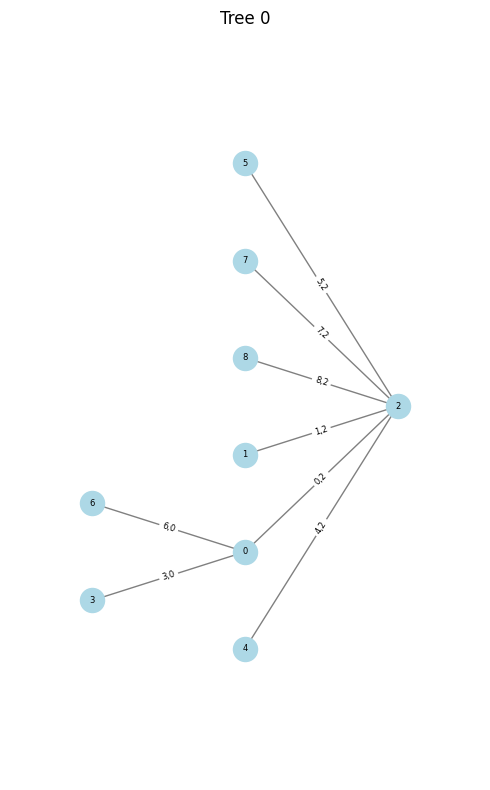

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-19 11:12:07,494] A new study created in RDB with name: no-name-1ae625df-0690-4b19-b81c-990b0bfbc889
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<11:14,  2.96it/s]

current_loss: tensor(1.4509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4220433235168457
current_loss: tensor(1.4475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4146164655685425
current_loss: tensor(1.4421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.0123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.412604808807373
current_loss: tensor(1.4410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 7/2000 [00:00<02:09, 15.35it/s]

tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4100229740142822
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.408263087272644
current_loss: tensor(1.4387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.40744149684906
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4074872732162476
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4076206684112549
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', 

  0%|          | 10/2000 [00:00<02:30, 13.19it/s]


current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4078787565231323
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.408115267753601
Early Stop at iteration 10 with minimal loss tensor(1.4074, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4392, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<05:54,  5.64it/s]

current_loss: tensor(1.4301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3356287479400635
current_loss: tensor(1.3593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.210889458656311
current_loss: tensor(1.2319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1704, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:36,  9.21it/s]

current_loss_val:  1.1504309177398682
current_loss: tensor(1.1704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1423858404159546
current_loss: tensor(1.1625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1430, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:04, 10.78it/s]

current_loss_val:  1.1230403184890747
current_loss: tensor(1.1430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0945075750350952
current_loss: tensor(1.1146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.087357521057129
current_loss: tensor(1.1111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:47, 11.87it/s]

current_loss_val:  1.0749233961105347
current_loss: tensor(1.0974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072014331817627
current_loss: tensor(1.0939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.066057562828064
current_loss: tensor(1.0870, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0832, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:30, 13.19it/s]

current_loss_val:  1.062583088874817
current_loss: tensor(1.0832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0573762655258179
current_loss: tensor(1.0773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552184581756592
current_loss: tensor(1.0746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0671, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:26, 13.50it/s]

current_loss_val:  1.0488945245742798
current_loss: tensor(1.0671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0432237386703491
current_loss: tensor(1.0617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0307939052581787
current_loss: tensor(1.0488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:22, 13.88it/s]

current_loss_val:  1.0267033576965332
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0239816904067993
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0227413177490234
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:21, 13.96it/s]

current_loss_val:  1.0211865901947021
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0092151165008545
current_loss: tensor(1.0301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.992472231388092
current_loss: tensor(1.0161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:18, 14.23it/s]

current_loss_val:  0.9799303412437439
current_loss: tensor(1.0047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.976439893245697
current_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721920490264893
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:22, 13.88it/s]

current_loss_val:  0.9700907468795776
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669188261032104
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9617652297019958
current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:28, 13.27it/s]

current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590285420417786
current_loss: tensor(0.9816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578452706336975
current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:31, 12.96it/s]

current_loss_val:  0.955815315246582
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530542492866516
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9524796009063721
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:27, 13.33it/s]

current_loss_val:  0.9501700401306152
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498066306114197
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483999609947205
current_loss: 

  2%|▏         | 39/2000 [00:03<02:32, 12.89it/s]

tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482107162475586
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9481084942817688
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480108618736267


  2%|▏         | 41/2000 [00:03<02:27, 13.27it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9478622078895569
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476027488708496
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9473413825035095


  2%|▏         | 45/2000 [00:03<02:22, 13.70it/s]

current_loss: tensor(0.9682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470236897468567
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9463346600532532
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9455589056015015


  2%|▏         | 47/2000 [00:03<02:20, 13.90it/s]

current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9443476796150208
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9428509473800659
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9406918287277222


  2%|▏         | 49/2000 [00:03<02:26, 13.33it/s]

current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.936966061592102
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9333862662315369
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:21, 13.74it/s]

current_loss_val:  0.9297278523445129
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9285169243812561
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927040159702301
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:19, 13.90it/s]

current_loss_val:  0.9234594106674194
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.921915590763092
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9205937385559082
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:24, 13.46it/s]

current_loss_val:  0.9190315008163452
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176732897758484
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9165676236152649
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:28, 13.03it/s]

current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9160243272781372
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9150770306587219
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145206212997437


  3%|▎         | 65/2000 [00:04<02:21, 13.66it/s]

current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143124222755432
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144809246063232
current_loss: tensor(0.9394, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9136872887611389


  3%|▎         | 67/2000 [00:05<02:33, 12.60it/s]

current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128668904304504
current_loss: tensor(0.9363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132006168365479
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:27, 13.08it/s]

current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131418466567993
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131306409835815
current_loss: tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134196043014526
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:30, 12.82it/s]


current_loss: tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9135740399360657
Early Stop at iteration 70 with minimal loss tensor(0.9129, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:17,161] Trial 0 finished with value: -8.215802192687988 and parameters: {'penalty_decorrelation_ridge_first_difference': 16.440448658111777, 'penalty_decorrelation_ridge_second_difference': 2.8377147445735633}. Best is trial 0 with value: -8.215802192687988.
  0%|          | 2/2000 [00:00<02:26, 13.68it/s]

current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133949875831604
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128881692886353
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124776721000671


  0%|          | 6/2000 [00:00<02:20, 14.16it/s]

current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912389874458313
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140885472297668
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124149680137634


  0%|          | 8/2000 [00:00<02:20, 14.17it/s]

current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123766422271729
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124162197113037
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124483466148376


  1%|          | 12/2000 [00:00<02:19, 14.26it/s]

current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125656485557556
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912268877029419
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123170971870422


  1%|          | 14/2000 [00:00<02:18, 14.30it/s]

current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119141697883606
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118886590003967
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118072986602783


  1%|          | 18/2000 [00:01<02:18, 14.28it/s]

current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116973876953125
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114171266555786
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911258339881897


  1%|          | 20/2000 [00:01<02:25, 13.58it/s]

current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110313653945923
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910932719707489
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:24, 13.71it/s]

current_loss_val:  0.9107221364974976
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910362184047699
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102078676223755
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:20, 14.06it/s]

current_loss_val:  0.9096242785453796
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093805551528931
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086375832557678
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:40, 12.28it/s]

current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9079386591911316
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065471887588501
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:42, 12.15it/s]

current_loss_val:  0.9031031727790833
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9030258059501648
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9029753804206848
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:36, 12.54it/s]

current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9026452302932739
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9023637175559998
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9024940133094788


  2%|▏         | 36/2000 [00:02<02:31, 12.97it/s]

current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.90257728099823
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9026026725769043
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9027080535888672


  2%|▏         | 37/2000 [00:02<02:29, 13.09it/s]


current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9024437069892883
Early Stop at iteration 37 with minimal loss tensor(0.9024, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:20,542] Trial 1 finished with value: -8.121273040771484 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.678566910280291, 'penalty_decorrelation_ridge_second_difference': 14.520954956743012}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131101369857788
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132593274116516
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<04:34,  7.27it/s]

current_loss_val:  0.9125973582267761
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125164747238159
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126899242401123
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:18, 10.01it/s]

current_loss_val:  0.9130467772483826
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144778847694397
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142838716506958
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:51,  8.62it/s]


current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9141678810119629
Early Stop at iteration 8 with minimal loss tensor(0.9125, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:22,091] Trial 2 finished with value: -8.212648391723633 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.512132649430754, 'penalty_decorrelation_ridge_second_difference': 26.231448693551616}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:23, 13.94it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134009480476379
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129077792167664
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124607443809509


  0%|          | 4/2000 [00:00<02:21, 14.12it/s]

current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123762845993042
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126125574111938
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:27, 13.49it/s]

current_loss_val:  0.9124006032943726
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124126434326172
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125353693962097
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:51, 11.64it/s]


current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125514626502991
Early Stop at iteration 8 with minimal loss tensor(0.9124, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:23,369] Trial 3 finished with value: -8.211386680603027 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.946457287093349, 'penalty_decorrelation_ridge_second_difference': 14.601790528127873}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:21, 14.10it/s]

current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130892157554626
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914111316204071
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:34, 12.91it/s]

current_loss_val:  0.9140586256980896
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142814874649048
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9148867130279541
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:59, 11.12it/s]


current_loss_val:  0.9157832264900208
Early Stop at iteration 5 with minimal loss tensor(0.9131, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:24,421] Trial 4 finished with value: -8.217803001403809 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.425859590631738, 'penalty_decorrelation_ridge_second_difference': 16.988763774368678}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 1/2000 [00:00<04:10,  7.99it/s]

current_loss: tensor(0.9487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130798578262329
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:57,  8.42it/s]

current_loss_val:  0.9135039448738098
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128821492195129
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128515720367432
current_loss: tensor(0.9409, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:45, 12.07it/s]

current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132208228111267
current_loss: tensor(0.9396, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913983941078186
current_loss: tensor(0.9385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9151791334152222
current_loss: tensor(0.9366, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:24,  9.76it/s]


current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145035743713379
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143604636192322
Early Stop at iteration 8 with minimal loss tensor(0.9129, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:25,849] Trial 5 finished with value: -8.21566390991211 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.314678813947172, 'penalty_decorrelation_ridge_second_difference': 25.202397645295825}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:24, 13.78it/s]

current_loss: tensor(0.9414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130764007568359
current_loss: tensor(0.9401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133865237236023
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:40, 12.43it/s]

current_loss_val:  0.9127137660980225
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126640558242798
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129413962364197
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:37, 12.67it/s]

current_loss_val:  0.9136251211166382
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146853685379028
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139430522918701
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:54, 11.43it/s]


current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139297008514404
Early Stop at iteration 8 with minimal loss tensor(0.9127, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:27,131] Trial 6 finished with value: -8.213976860046387 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.516080409986477, 'penalty_decorrelation_ridge_second_difference': 27.083670843709456}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<03:30,  9.48it/s]

current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129499793052673
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126074314117432


  0%|          | 4/2000 [00:00<03:07, 10.62it/s]

current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126428961753845
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9309, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126508235931396
current_loss: tensor(0.9304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:20,  9.97it/s]

current_loss_val:  0.9127773642539978
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912958025932312
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913240909576416
Early Stop at iteration 6 with minimal loss tensor(0.9126, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:12:28,321] Trial 7 finished with value: -8.21346664428711 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.451110913546593, 'penalty_decorrelation_ridge_second_difference': 3.7223051663895506}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:24, 13.83it/s]

current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91340571641922
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128608107566833
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126403331756592


  0%|          | 4/2000 [00:00<02:23, 13.94it/s]

current_loss: tensor(0.9266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125754237174988
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123421311378479
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:28, 13.42it/s]

current_loss_val:  0.9124841690063477
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123919606208801
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912438690662384
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:48, 11.84it/s]


current_loss_val:  0.9126219749450684
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127832055091858
Early Stop at iteration 9 with minimal loss tensor(0.9123, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:29,629] Trial 8 finished with value: -8.211078643798828 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.886425018345233, 'penalty_decorrelation_ridge_second_difference': 9.798448691101386}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<03:12, 10.37it/s]

current_loss: tensor(0.9299, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129287004470825
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125345349311829
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:41, 12.33it/s]

current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124796986579895
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128411412239075
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127177596092224
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:27, 13.49it/s]

current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127255082130432
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912701427936554
current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124199151992798
current_loss: tensor(0.9261, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:33, 12.93it/s]

current_loss: tensor(0.9264, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117704033851624
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116472601890564
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116487503051758


  1%|          | 14/2000 [00:01<02:25, 13.66it/s]

current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121200442314148
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911827802658081
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116429090499878


  1%|          | 16/2000 [00:01<02:28, 13.41it/s]

current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109880924224854
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111649394035339
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:35, 12.72it/s]

current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111116528511047
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110784530639648
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110429883003235
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:40, 12.35it/s]


current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112593531608582
Early Stop at iteration 19 with minimal loss tensor(0.9110, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:31,799] Trial 9 finished with value: -8.198892593383789 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.20734725474527, 'penalty_decorrelation_ridge_second_difference': 0.9364121230416913}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:26, 13.66it/s]

current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131467938423157
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134408831596375
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:38, 12.58it/s]

current_loss_val:  0.9130301475524902
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129987955093384
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133747816085815
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:26, 13.57it/s]

current_loss_val:  0.9137043356895447
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9167546629905701
current_loss: tensor(0.9410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9168623089790344
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9390, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:46, 11.96it/s]


current_loss_val:  0.9160722494125366
Early Stop at iteration 8 with minimal loss tensor(0.9130, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:33,015] Trial 10 finished with value: -8.21699047088623 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.550842627660657, 'penalty_decorrelation_ridge_second_difference': 19.982236846008323}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<03:10, 10.47it/s]

current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129334688186646
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122733473777771
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.38it/s]

current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120604395866394
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122422933578491
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123398661613464


  0%|          | 7/2000 [00:00<03:02, 10.93it/s]

current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124112725257874
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127103090286255
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124279618263245
Early Stop at iteration 7 with minimal loss tensor(0.9121, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:12:34,236] Trial 11 finished with value: -8.20854377746582 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1270861526630223, 'penalty_decorrelation_ridge_second_difference': 1.5893598577778225}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 1/2000 [00:00<03:22,  9.87it/s]

current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129610657691956
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126278162002563
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:52, 11.58it/s]

current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127673506736755
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912804126739502
current_loss: tensor(0.9324, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129602909088135


  0%|          | 6/2000 [00:00<03:14, 10.28it/s]


current_loss: tensor(0.9320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131879210472107
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913498044013977
Early Stop at iteration 6 with minimal loss tensor(0.9126, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:35,393] Trial 12 finished with value: -8.213650703430176 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.643941632449678, 'penalty_decorrelation_ridge_second_difference': 3.7137877595087354}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:23, 13.92it/s]

current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91302889585495
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138920307159424
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:35, 12.87it/s]

current_loss_val:  0.9132245182991028
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132562875747681
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9141644835472107
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:08, 10.58it/s]


current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9155069589614868
Early Stop at iteration 5 with minimal loss tensor(0.9130, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:36,454] Trial 13 finished with value: -8.217259407043457 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.435173865326817, 'penalty_decorrelation_ridge_second_difference': 26.341940936860095}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:19, 14.29it/s]

current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129884839057922
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142199754714966
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:34, 12.90it/s]

current_loss_val:  0.9137161374092102
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137730002403259
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9164667129516602
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:21,  9.91it/s]


current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9177987575531006
Early Stop at iteration 5 with minimal loss tensor(0.9130, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:37,525] Trial 14 finished with value: -8.216896057128906 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.446132012118767, 'penalty_decorrelation_ridge_second_difference': 28.810738270386704}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:25, 13.69it/s]

current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133195877075195
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132447838783264
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:37, 12.69it/s]

current_loss_val:  0.9131951332092285
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132265448570251
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144895076751709
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:48, 11.86it/s]

current_loss_val:  0.9161302447319031
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9153162837028503
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146830439567566
Early Stop at iteration 7 with minimal loss tensor(0.9132, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:12:38,702] Trial 15 finished with value: -8.218756675720215 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.17546887714974, 'penalty_decorrelation_ridge_second_difference': 9.124410698806399}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<02:20, 14.18it/s]

current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913482666015625
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.913045346736908
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127251505851746


  0%|          | 4/2000 [00:00<02:21, 14.09it/s]

current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128731489181519
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9144821166992188
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:48, 11.86it/s]

current_loss_val:  0.9148843288421631
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915373682975769
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9184514880180359
Early Stop at iteration 7 with minimal loss tensor(0.9127, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:12:39,847] Trial 16 finished with value: -8.214526176452637 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.29342446261974, 'penalty_decorrelation_ridge_second_difference': 1.907319002973886}. Best is trial 1 with value: -8.121273040771484.
  0%|          | 2/2000 [00:00<03:12, 10.38it/s]

current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129499793052673
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123719930648804
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.26it/s]

current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120834469795227
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119179844856262
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91195148229599
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:29, 13.36it/s]

current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120997190475464
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120168089866638
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115283489227295
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:43, 12.17it/s]

current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114415049552917
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108566641807556
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:36, 12.71it/s]

current_loss_val:  0.910803496837616
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091354608535767
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090808629989624
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:30, 13.16it/s]

current_loss_val:  0.9086191654205322
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9084806442260742
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:47, 11.85it/s]

current_loss_val:  0.9083098769187927
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9080278277397156
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9076798558235168
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:39, 12.40it/s]

current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907447338104248
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9072564244270325
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068664312362671


  1%|          | 24/2000 [00:01<02:34, 12.76it/s]

current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066816568374634
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065732955932617
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063788056373596


  1%|▏         | 26/2000 [00:02<02:30, 13.10it/s]

current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061166644096375
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9060759544372559
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9060208201408386


  2%|▏         | 30/2000 [00:02<02:25, 13.53it/s]

current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054089784622192
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9051808714866638
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9051017761230469


  2%|▏         | 32/2000 [00:02<02:24, 13.60it/s]

current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9048848748207092
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9042714834213257
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9038615822792053


  2%|▏         | 36/2000 [00:02<02:22, 13.80it/s]

current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9026970863342285
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9022918343544006
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9012990593910217


  2%|▏         | 38/2000 [00:02<02:21, 13.90it/s]

current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9011027812957764
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9010506868362427
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:27, 13.25it/s]

current_loss_val:  0.9012683033943176
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9012702107429504
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9014055728912354
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:34, 12.69it/s]

current_loss_val:  0.9013563394546509
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9015542268753052
Early Stop at iteration 42 with minimal loss tensor(0.9011, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:12:43,722] Trial 17 finished with value: -8.109456062316895 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3687949857431292, 'penalty_decorrelation_ridge_second_difference': 11.097835816699712}. Best is trial 17 with value: -8.109456062316895.
  0%|          | 2/2000 [00:00<03:11, 10.45it/s]

current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129371047019958
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123257398605347
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.31it/s]

current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120000004768372
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911902904510498
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118500351905823
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:28, 13.41it/s]

current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119001626968384
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118613600730896
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114781022071838
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:35, 12.77it/s]

current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107152819633484
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106575846672058
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107337594032288


  1%|          | 12/2000 [00:00<02:39, 12.45it/s]

current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9103207588195801
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098182916641235
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:37, 12.61it/s]

current_loss_val:  0.908612847328186
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9079309701919556
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074416160583496
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:32, 12.98it/s]

current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906816840171814
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905735194683075
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905373215675354


  1%|          | 22/2000 [00:01<02:31, 13.03it/s]

current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050702452659607
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9035435914993286
current_loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9026853442192078


  1%|          | 24/2000 [00:01<02:28, 13.35it/s]

current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9027011394500732
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9027929902076721
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9023846387863159


  1%|▏         | 28/2000 [00:02<02:24, 13.67it/s]

current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9023805260658264
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.901483952999115
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9013947248458862


  2%|▏         | 30/2000 [00:02<02:22, 13.79it/s]

current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9011606574058533
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9006495475769043
current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.900394856929779


  2%|▏         | 32/2000 [00:02<02:26, 13.44it/s]

current_loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9003116488456726
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.900080680847168
current_loss: tensor(0.8935, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:44, 11.98it/s]

current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999350666999817
current_loss: tensor(0.8934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8998470306396484
current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8930, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:39, 12.27it/s]

current_loss_val:  0.8997916579246521
current_loss: tensor(0.8930, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8996371626853943
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8996129035949707
current_loss: tensor(0.8927, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:33, 12.74it/s]

current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8994457125663757
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.899246871471405
current_loss: tensor(0.8922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8996068835258484
current_loss: tensor(0.8920, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:31, 12.95it/s]

current_loss: tensor(0.8919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8985618352890015
current_loss: tensor(0.8912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8983787298202515
current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897746205329895


  2%|▏         | 46/2000 [00:03<02:26, 13.32it/s]

current_loss: tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897980809211731
current_loss: tensor(0.8901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897919774055481
current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:32, 12.78it/s]

current_loss_val:  0.8975228071212769
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897519052028656
current_loss: tensor(0.8896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8975754380226135
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:29, 12.99it/s]

current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8975564241409302
current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8975954055786133
current_loss: tensor(0.8891, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8974823355674744
current_loss: tensor(0.8889, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:34, 12.62it/s]

current_loss: tensor(0.8890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897221028804779
current_loss: tensor(0.8888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8970799446105957
current_loss: tensor(0.8887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8969568014144897


  3%|▎         | 58/2000 [00:04<02:26, 13.26it/s]

current_loss: tensor(0.8886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8968549370765686
current_loss: tensor(0.8885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.896828830242157
current_loss: tensor(0.8883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8967370986938477


  3%|▎         | 60/2000 [00:04<02:23, 13.50it/s]

current_loss: tensor(0.8882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8964042067527771
current_loss: tensor(0.8879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8963096737861633
current_loss: tensor(0.8875, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8962902426719666


  3%|▎         | 62/2000 [00:04<02:21, 13.65it/s]

current_loss: tensor(0.8873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.896109402179718
current_loss: tensor(0.8862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8955564498901367
current_loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:30, 12.87it/s]

current_loss_val:  0.8956236839294434
current_loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8961690664291382
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8959229588508606
current_loss: tensor(0.8838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8833, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:32, 12.69it/s]


current_loss_val:  0.897648811340332
current_loss: tensor(0.8833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8974238038063049
Early Stop at iteration 67 with minimal loss tensor(0.8956, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:49,590] Trial 18 finished with value: -8.06000804901123 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.40853719449676174, 'penalty_decorrelation_ridge_second_difference': 10.33613362112087}. Best is trial 18 with value: -8.06000804901123.
  0%|          | 2/2000 [00:00<03:40,  9.06it/s]

current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91291743516922
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122790098190308


  0%|          | 4/2000 [00:00<03:17, 10.12it/s]

current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119033217430115
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912136971950531
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:54, 11.45it/s]

current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117701649665833
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117289781570435
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116818904876709
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:35, 12.77it/s]

current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113863110542297
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910358726978302
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910403847694397
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:31, 13.10it/s]

current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105971455574036
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910464882850647
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098647832870483
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:28, 13.39it/s]

current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090489745140076
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087287187576294
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:10, 10.39it/s]

current_loss_val:  0.9087694883346558
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074317812919617
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9072487354278564
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<03:19,  9.94it/s]

current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065134525299072
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066757559776306
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<03:02, 10.84it/s]

current_loss_val:  0.9066371321678162
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065549969673157
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065688848495483
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:53, 11.38it/s]

current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064606428146362
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065032601356506
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067016839981079


  1%|▏         | 28/2000 [00:02<02:59, 10.99it/s]

current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067482948303223
current_loss: tensor(0.8993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068123698234558
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069875478744507
Early Stop at iteration 28 with minimal loss tensor(0.9065, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:12:52,755] Trial 19 finished with value: -8.158145904541016 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.40005771292141845, 'penalty_decorrelation_ridge_second_difference': 6.862892288434646}. Best is trial 18 with value: -8.06000804901123.
  0%|          | 2/2000 [00:00<02:26, 13.65it/s]

current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133889079093933
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129325151443481
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123359322547913


  0%|          | 6/2000 [00:00<02:25, 13.69it/s]

current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123370051383972
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122591018676758
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123188257217407


  0%|          | 8/2000 [00:00<02:27, 13.52it/s]

current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124147295951843
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126766324043274
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:43, 12.18it/s]


current_loss_val:  0.912670910358429
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127517342567444
Early Stop at iteration 9 with minimal loss tensor(0.9123, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:12:54,062] Trial 20 finished with value: -8.210331916809082 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.855295966028881, 'penalty_decorrelation_ridge_second_difference': 18.25052996737159}. Best is trial 18 with value: -8.06000804901123.
  0%|          | 2/2000 [00:00<02:24, 13.84it/s]

current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133771657943726
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912841260433197
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125397205352783


  0%|          | 4/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124581217765808
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119886159896851
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:40, 12.43it/s]

current_loss_val:  0.912020206451416
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119133353233337
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121063351631165
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.87it/s]

current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121420383453369
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118269681930542
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911661684513092
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:28, 13.37it/s]

current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911421000957489
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111753702163696
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108729362487793
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.55it/s]

current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108340740203857
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910801112651825
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107192158699036
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:25, 13.64it/s]

current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910626232624054
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105352759361267
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105010032653809
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.05it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9103497266769409
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9099916815757751
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098365902900696


  1%|          | 24/2000 [00:01<02:29, 13.24it/s]

current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087603688240051
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067874550819397
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:30, 13.07it/s]

current_loss_val:  0.9061625599861145
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9051035046577454
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043421149253845
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:35, 12.70it/s]

current_loss_val:  0.9039417505264282
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9030748009681702
current_loss: tensor(0.9007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9025204181671143
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:43, 12.06it/s]

current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9024275541305542
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9021503329277039
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:40, 12.20it/s]

current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9020143151283264
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9020795226097107
current_loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9021148681640625
current_loss: tensor(0.8983, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:34, 12.69it/s]

current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9016837477684021
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9017918109893799
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9016199111938477
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:29, 13.11it/s]

current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9015365839004517
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9014484882354736
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9010615944862366
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:31, 12.94it/s]

current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9001350998878479
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9002398252487183
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9003312587738037


  2%|▏         | 46/2000 [00:03<02:27, 13.26it/s]

current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9003646969795227
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9002575874328613
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:36, 12.44it/s]

current_loss_val:  0.9000192880630493
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8993822932243347
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8988462090492249
current_loss: tensor(0.8941, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:36, 12.48it/s]

current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8979566693305969
current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8974719047546387
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897271454334259


  3%|▎         | 54/2000 [00:04<02:32, 12.79it/s]

current_loss: tensor(0.8924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8972631096839905
current_loss: tensor(0.8921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8972426056861877
current_loss: tensor(0.8917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8912, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:30, 12.91it/s]

current_loss_val:  0.89711993932724
current_loss: tensor(0.8912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8971917629241943
current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8972192406654358
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8905, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:36, 12.37it/s]

current_loss_val:  0.8967809081077576
current_loss: tensor(0.8905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8968666791915894
current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8968895673751831
current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:27, 13.10it/s]

current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897042989730835
current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.896936297416687
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8965698480606079
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:24, 13.35it/s]

current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8963284492492676
current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8960210680961609
current_loss: tensor(0.8887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8955212831497192
current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:22, 13.58it/s]

current_loss: tensor(0.8881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8954210877418518
current_loss: tensor(0.8881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8952960968017578
current_loss: tensor(0.8878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8952502012252808
current_loss: tensor(0.8868, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:27, 13.05it/s]

current_loss: tensor(0.8879, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8949491381645203
current_loss: tensor(0.8865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.894870936870575
current_loss: tensor(0.8863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8950726985931396


  4%|▎         | 74/2000 [00:05<02:24, 13.37it/s]

current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8950314521789551
current_loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8950513601303101
current_loss: tensor(0.8855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8948574662208557


  4%|▍         | 78/2000 [00:06<02:22, 13.47it/s]

current_loss: tensor(0.8854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.894779622554779
current_loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8946484923362732
current_loss: tensor(0.8852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8850, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:27, 12.98it/s]

current_loss_val:  0.8945877552032471
current_loss: tensor(0.8850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8947083950042725
current_loss: tensor(0.8848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8945493698120117
current_loss: tensor(0.8848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:23, 13.35it/s]

current_loss_val:  0.8943042159080505
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8943017721176147
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.894238293170929
current_loss: tensor(0.8844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8842, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 86/2000 [00:06<02:28, 12.91it/s]

current_loss_val:  0.89433753490448
current_loss: tensor(0.8842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8942464590072632
current_loss: tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8941951990127563


  4%|▍         | 88/2000 [00:06<02:30, 12.71it/s]

current_loss: tensor(0.8840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8935003280639648
current_loss: tensor(0.8837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.893629789352417
current_loss: tensor(0.8835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8835, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 92/2000 [00:07<02:24, 13.16it/s]

current_loss_val:  0.8936659097671509
current_loss: tensor(0.8835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8937631845474243
current_loss: tensor(0.8832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.893720269203186
current_loss: tensor(0.8829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8831, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:07<02:28, 12.87it/s]

current_loss: tensor(0.8826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8930923938751221
current_loss: tensor(0.8826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8930555582046509
current_loss: tensor(0.8824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8930615186691284
current_loss: tensor(0.8824, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 98/2000 [00:07<02:26, 13.01it/s]

current_loss: tensor(0.8822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.893146812915802
current_loss: tensor(0.8822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.893110454082489
current_loss: tensor(0.8820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8926418423652649


  5%|▌         | 100/2000 [00:07<02:23, 13.27it/s]

current_loss: tensor(0.8819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8926454782485962
current_loss: tensor(0.8818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8926475048065186
current_loss: tensor(0.8817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8817, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:07<02:28, 12.77it/s]

current_loss_val:  0.8925102353096008
current_loss: tensor(0.8817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8924967050552368
current_loss: tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8925144076347351
current_loss: tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 106/2000 [00:08<02:23, 13.21it/s]

current_loss_val:  0.892526388168335
current_loss: tensor(0.8816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8925454616546631
current_loss: tensor(0.8815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8926884531974792
current_loss: tensor(0.8815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8815, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 106/2000 [00:08<02:27, 12.87it/s]


current_loss_val:  0.8926516175270081
Early Stop at iteration 106 with minimal loss tensor(0.8925, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:13:02,873] Trial 21 finished with value: -8.032469749450684 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.01503081185383437, 'penalty_decorrelation_ridge_second_difference': 13.985421638030408}. Best is trial 21 with value: -8.032469749450684.
  0%|          | 2/2000 [00:00<03:11, 10.43it/s]

current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129360914230347
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123407006263733
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.22it/s]

current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120303988456726
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911945641040802
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118862152099609
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.26it/s]

current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119340181350708
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119024872779846
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115440845489502
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.74it/s]

current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107887744903564
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107336401939392
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107652902603149
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:58,  8.32it/s]

current_loss_val:  0.910563588142395
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9103289842605591
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<04:45,  6.95it/s]

current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089994430541992
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9088900685310364
current_loss: tensor(0.9055, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:55,  8.43it/s]

current_loss_val:  0.908219575881958
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064980149269104
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057062864303589
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:04, 10.71it/s]

current_loss_val:  0.9050101637840271
current_loss: tensor(0.9023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049774408340454
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050029516220093
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:51, 11.54it/s]

current_loss_val:  0.9049294590950012
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9042871594429016
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043510556221008
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:41, 12.24it/s]

current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043506979942322
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904341459274292
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904106616973877
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:42, 12.12it/s]

current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9038881063461304
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9038082957267761
current_loss: tensor(0.8998, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9029577970504761


  2%|▏         | 31/2000 [00:02<02:42, 12.14it/s]

current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9028675556182861
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9023318290710449
current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<02:33, 12.78it/s]

current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9016714692115784
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9011647701263428
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9007983207702637
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:28, 13.25it/s]

current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9008007049560547
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9010676741600037
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9008615016937256
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:21, 13.86it/s]

current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9006326198577881
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9005084037780762
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9008469581604004
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:19, 14.00it/s]

current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9004635810852051
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9003288745880127
current_loss: tensor(0.8958, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<02:38, 12.37it/s]

current_loss_val:  0.9001871943473816
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9002212285995483
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9000864624977112
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<02:31, 12.90it/s]

current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8998976945877075
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999220132827759
current_loss: tensor(0.8953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8997641205787659
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<02:27, 13.20it/s]

current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9000412225723267
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999534249305725
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999233841896057
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:52, 11.32it/s]

current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999135494232178
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9000827670097351
Early Stop at iteration 53 with minimal loss tensor(0.8998, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:13:08,144] Trial 22 finished with value: -8.09787654876709 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2976036651532246, 'penalty_decorrelation_ridge_second_difference': 9.9294719716264}. Best is trial 21 with value: -8.032469749450684.
  0%|          | 2/2000 [00:00<02:28, 13.49it/s]

current_loss: tensor(0.9391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134145975112915
current_loss: tensor(0.9387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130171537399292
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126375913619995


  0%|          | 6/2000 [00:00<02:24, 13.82it/s]

current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131205677986145
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129646420478821
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132834076881409


  0%|          | 7/2000 [00:00<02:44, 12.13it/s]


current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132737517356873
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9327, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137229919433594
Early Stop at iteration 7 with minimal loss tensor(0.9126, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:13:09,268] Trial 23 finished with value: -8.213738441467285 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.86400074516477, 'penalty_decorrelation_ridge_second_difference': 13.58984835854445}. Best is trial 21 with value: -8.032469749450684.
  0%|          | 1/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129285216331482
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124148488044739
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:40, 12.43it/s]

current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121900200843811
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122224450111389
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121190309524536
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:32, 13.04it/s]

current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121515154838562
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121372699737549
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911861777305603
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:32, 13.01it/s]

current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111797213554382
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110991954803467
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111006855964661


  1%|          | 13/2000 [00:01<02:37, 12.62it/s]

current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110816121101379
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110846519470215
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:34, 12.87it/s]

current_loss_val:  0.9108998775482178
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102453589439392
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095771312713623
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:28, 13.32it/s]

current_loss_val:  0.9094589352607727
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087443947792053
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9070336222648621
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:32, 12.97it/s]

current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069252610206604
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068073630332947
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064028859138489
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:25, 13.60it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905796468257904
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054213166236877
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054213166236877
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:22, 13.81it/s]

current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054027199745178
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9051634073257446
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9045873284339905
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:20, 14.06it/s]

current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9044719338417053
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9044077396392822
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9035423398017883
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:31, 13.02it/s]

current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9028252363204956
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9020848870277405
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:28, 13.26it/s]

current_loss_val:  0.901818573474884
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999882340431213
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8995586037635803
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:31, 12.98it/s]

current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8994699120521545
current_loss: tensor(0.9018, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8991878628730774
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8989866375923157
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:28, 13.24it/s]

current_loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8989374041557312
current_loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8989189267158508
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8988305330276489
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:29, 13.08it/s]

current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8987170457839966
current_loss: tensor(0.9009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8987014889717102
current_loss: tensor(0.9008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8987849950790405


  2%|▏         | 47/2000 [00:03<02:40, 12.20it/s]

current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8988291025161743
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.898726224899292
current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:42, 12.03it/s]

current_loss: tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8982507586479187
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8983774781227112
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:36, 12.44it/s]

current_loss_val:  0.8983826637268066
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8984525799751282
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8985679149627686
current_loss: tensor(0.8989, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:33, 12.69it/s]


current_loss_val:  0.8983531594276428
Early Stop at iteration 52 with minimal loss tensor(0.8983, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:13:13,976] Trial 24 finished with value: -8.084257125854492 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.266325860048506, 'penalty_decorrelation_ridge_second_difference': 6.903996324082704}. Best is trial 21 with value: -8.032469749450684.
  0%|          | 2/2000 [00:00<03:13, 10.34it/s]

current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129368662834167
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124698638916016
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.16it/s]

current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91231769323349
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123597145080566
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123175144195557
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.19it/s]

current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912388265132904
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123659133911133
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120465517044067
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:36, 12.68it/s]

current_loss: tensor(0.9210, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114253520965576
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113966822624207
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114835262298584


  1%|          | 12/2000 [00:00<02:41, 12.33it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115034937858582
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911457896232605
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 13.03it/s]

current_loss_val:  0.9110764265060425
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9100168943405151
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092824459075928
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:29, 13.28it/s]

current_loss_val:  0.9092205166816711
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090467691421509
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087486267089844
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:34, 12.80it/s]

current_loss_val:  0.9076283574104309
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9076193571090698
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9075304269790649
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:29, 13.23it/s]

current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907268762588501
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9070759415626526
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066599011421204
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:22, 13.85it/s]

current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064451456069946
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9062932133674622
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063335657119751
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:20, 14.01it/s]

current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061720371246338
current_loss: tensor(0.9124, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9059193730354309
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9042962193489075
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:23, 13.66it/s]

current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.903901219367981
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9035457372665405
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9015148878097534


  2%|▏         | 36/2000 [00:02<02:21, 13.88it/s]

current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9005863070487976
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.899945080280304
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:35, 12.63it/s]

current_loss_val:  0.8997788429260254
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8992233872413635
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8993715047836304
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:29, 13.09it/s]

current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8989580869674683
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8983770608901978
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8986903429031372
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:26, 13.33it/s]

current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8987554311752319
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.89900141954422
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8989183306694031
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:31, 12.89it/s]


current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8994631767272949
Early Stop at iteration 45 with minimal loss tensor(0.8984, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:13:18,096] Trial 25 finished with value: -8.085393905639648 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.393569759377272, 'penalty_decorrelation_ridge_second_difference': 6.6253656758478}. Best is trial 21 with value: -8.032469749450684.
  0%|          | 2/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129178524017334
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123435616493225
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:43, 12.18it/s]

current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120572805404663
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127147197723389
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120384454727173
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.09it/s]

current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119822382926941
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119186401367188
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115679264068604
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106586575508118


  1%|          | 12/2000 [00:01<03:14, 10.21it/s]

current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105455875396729
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106695055961609
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107122421264648


  1%|          | 14/2000 [00:01<03:05, 10.70it/s]

current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910639226436615
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9101138114929199
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:53, 11.41it/s]

current_loss_val:  0.9097269177436829
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908775806427002
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9080044627189636
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:39, 12.44it/s]

current_loss_val:  0.9074721336364746
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906976580619812
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9053957462310791
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:34, 12.84it/s]

current_loss_val:  0.9054862260818481
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9048705697059631
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039646983146667
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:28, 13.25it/s]

current_loss_val:  0.9044675827026367
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9037063717842102
current_loss: tensor(0.8997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9035704731941223
current_loss: tensor(0.8995, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:34, 12.79it/s]

current_loss_val:  0.9035101532936096
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9036137461662292
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9035179615020752


  2%|▏         | 30/2000 [00:02<02:39, 12.37it/s]

current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9035210013389587
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9032995104789734
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:33, 12.79it/s]

current_loss_val:  0.9031622409820557
current_loss: tensor(0.8974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9030337333679199
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9026505351066589
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:35, 12.61it/s]

current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9025163650512695
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.902151346206665
current_loss: tensor(0.8960, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9013056755065918
current_loss: tensor(0.8950, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:25, 13.47it/s]

current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9003583192825317
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.89985191822052
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8994448781013489
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:23, 13.65it/s]

current_loss: tensor(0.8935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8987685441970825
current_loss: tensor(0.8935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8983081579208374
current_loss: tensor(0.8932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8975546956062317
current_loss: tensor(0.8928, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:28, 13.19it/s]

current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8974712491035461
current_loss: tensor(0.8927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8960296511650085
current_loss: tensor(0.8916, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:40, 12.18it/s]

current_loss: tensor(0.8914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8951809406280518
current_loss: tensor(0.8914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8950700163841248
current_loss: tensor(0.8911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8952332139015198


  2%|▎         | 50/2000 [00:04<02:34, 12.65it/s]

current_loss: tensor(0.8909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8954492211341858
current_loss: tensor(0.8907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8958512544631958
current_loss: tensor(0.8903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<02:42, 12.00it/s]


current_loss_val:  0.8958795666694641
current_loss: tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8958141207695007
Early Stop at iteration 51 with minimal loss tensor(0.8951, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:13:22,941] Trial 26 finished with value: -8.05562973022461 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.217615624118701, 'penalty_decorrelation_ridge_second_difference': 1.543502133469702}. Best is trial 21 with value: -8.032469749450684.
  0%|          | 1/2000 [00:00<03:22,  9.89it/s]

current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912916898727417
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123618006706238
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:42, 12.28it/s]

current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120855331420898
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9126620292663574
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120528697967529
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:37, 12.63it/s]

current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120070338249207
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911955714225769
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116250276565552
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:33, 12.95it/s]

current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107229113578796
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106435775756836
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107993841171265
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:32, 13.04it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108148813247681
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107154011726379
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102567434310913
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:29, 13.28it/s]

current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098672270774841
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098110198974609
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909749448299408
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909460723400116
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094520211219788
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094753861427307
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:25, 13.55it/s]

current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095028042793274
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095078110694885
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094687700271606
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:25, 13.61it/s]

current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092504382133484
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9083969593048096
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9070590734481812
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:33, 12.89it/s]

current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063495397567749
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905957043170929
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9046800136566162


  2%|▏         | 31/2000 [00:02<02:26, 13.40it/s]

current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9051041007041931
current_loss: tensor(0.9016, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9046587347984314
current_loss: tensor(0.9011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039691090583801


  2%|▏         | 33/2000 [00:02<02:25, 13.51it/s]

current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9037734270095825
current_loss: tensor(0.9005, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.903347909450531
current_loss: tensor(0.9002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:25, 13.52it/s]

current_loss_val:  0.902471661567688
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9023061990737915
current_loss: tensor(0.8992, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9021281599998474
current_loss: tensor(0.8990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:22, 13.74it/s]

current_loss_val:  0.9018425345420837
current_loss: tensor(0.8987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9016431570053101
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9015117287635803
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:18, 14.10it/s]

current_loss_val:  0.9012224078178406
current_loss: tensor(0.8978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9008888602256775
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9004552960395813
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8968, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:18, 14.17it/s]

current_loss_val:  0.8999836444854736
current_loss: tensor(0.8968, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999607563018799
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8997728228569031
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:21, 13.83it/s]

current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999302387237549
current_loss: tensor(0.8962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8998730778694153
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8996447324752808
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:40, 12.17it/s]

current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8994475603103638
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8992441296577454
current_loss: tensor(0.8956, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:43, 11.92it/s]

current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8991847038269043
current_loss: tensor(0.8955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8993043303489685
current_loss: tensor(0.8954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:04<02:36, 12.41it/s]

current_loss_val:  0.8992478251457214
current_loss: tensor(0.8952, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8992080092430115
current_loss: tensor(0.8951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8994622230529785
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8947, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:30, 12.90it/s]

current_loss_val:  0.8991747498512268
current_loss: tensor(0.8947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8991052508354187
current_loss: tensor(0.8946, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8990008234977722
current_loss: tensor(0.8943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8942, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:35, 12.49it/s]

current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8989067673683167
current_loss: tensor(0.8939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8985378742218018
current_loss: tensor(0.8936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.898273766040802
current_loss: tensor(0.8934, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:28, 13.03it/s]

current_loss: tensor(0.8929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8983028531074524
current_loss: tensor(0.8929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8968361616134644
current_loss: tensor(0.8922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.896723747253418
current_loss: tensor(0.8920, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:32, 12.64it/s]

current_loss: tensor(0.8919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8966096043586731
current_loss: tensor(0.8913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8961576819419861
current_loss: tensor(0.8902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8896, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:30, 12.80it/s]

current_loss_val:  0.8962976336479187
current_loss: tensor(0.8896, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8958773016929626
current_loss: tensor(0.8893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8952459692955017
current_loss: tensor(0.8887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8886, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:27, 13.08it/s]

current_loss_val:  0.8951189517974854
current_loss: tensor(0.8886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8948643803596497
current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8948129415512085
current_loss: tensor(0.8884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8880, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:24, 13.31it/s]

current_loss_val:  0.8948407173156738
current_loss: tensor(0.8880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8951326012611389
current_loss: tensor(0.8876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8950548768043518
current_loss: tensor(0.8869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8871, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:06<02:27, 13.02it/s]

current_loss: tensor(0.8863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8950517773628235
current_loss: tensor(0.8863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8945915102958679
current_loss: tensor(0.8858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.894496738910675
current_loss: tensor(0.8856, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:06<02:24, 13.24it/s]

current_loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8949926495552063
current_loss: tensor(0.8853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8943029046058655
current_loss: tensor(0.8847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8941812515258789
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:06<02:23, 13.40it/s]

current_loss: tensor(0.8842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.893941342830658
current_loss: tensor(0.8842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8939209580421448
current_loss: tensor(0.8839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8837, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:06<02:26, 13.04it/s]

current_loss_val:  0.893782913684845
current_loss: tensor(0.8837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.893704354763031
current_loss: tensor(0.8836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8935204744338989
current_loss: tensor(0.8835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8834, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:06<02:24, 13.26it/s]

current_loss_val:  0.8935386538505554
current_loss: tensor(0.8834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8934822678565979
current_loss: tensor(0.8832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8934335112571716
current_loss: tensor(0.8832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8830, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:07<02:22, 13.42it/s]

current_loss_val:  0.8932758569717407
current_loss: tensor(0.8830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8932643532752991
current_loss: tensor(0.8829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8933007121086121
current_loss: tensor(0.8826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8827, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:07<02:27, 12.87it/s]

current_loss: tensor(0.8825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8931575417518616
current_loss: tensor(0.8825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8930640816688538
current_loss: tensor(0.8824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8927928805351257
current_loss: tensor(0.8822, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 99/2000 [00:07<02:25, 13.05it/s]

current_loss: tensor(0.8820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8925397992134094
current_loss: tensor(0.8820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8923986554145813
current_loss: tensor(0.8818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8922657370567322
current_loss: tensor(0.8817, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 101/2000 [00:07<02:23, 13.20it/s]

current_loss: tensor(0.8815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8922610878944397
current_loss: tensor(0.8815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8920460343360901
current_loss: tensor(0.8814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8919665813446045
current_loss: tensor(0.8812, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 105/2000 [00:08<02:24, 13.15it/s]

current_loss: tensor(0.8811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8919554352760315
current_loss: tensor(0.8811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8918653130531311
current_loss: tensor(0.8809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8916594982147217


  5%|▌         | 107/2000 [00:08<02:20, 13.49it/s]

current_loss: tensor(0.8808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.891596257686615
current_loss: tensor(0.8807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8914059996604919
current_loss: tensor(0.8803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8802, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 109/2000 [00:08<02:31, 12.51it/s]

current_loss_val:  0.8914275765419006
current_loss: tensor(0.8802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.891173243522644
current_loss: tensor(0.8799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8915742039680481
current_loss: tensor(0.8795, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 113/2000 [00:08<02:20, 13.41it/s]

current_loss: tensor(0.8787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8905758857727051
current_loss: tensor(0.8787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8902405500411987
current_loss: tensor(0.8786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8900853395462036
current_loss: tensor(0.8785, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 115/2000 [00:08<02:19, 13.53it/s]

current_loss: tensor(0.8783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.889892578125
current_loss: tensor(0.8783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8906422853469849
current_loss: tensor(0.8783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8780, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 117/2000 [00:08<02:34, 12.22it/s]

current_loss_val:  0.8901384472846985
current_loss: tensor(0.8780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8900627493858337
current_loss: tensor(0.8780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8899362087249756
current_loss: tensor(0.8779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8779, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 118/2000 [00:09<02:25, 12.95it/s]


current_loss_val:  0.8900055289268494
Early Stop at iteration 118 with minimal loss tensor(0.8899, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:13:32,644] Trial 27 finished with value: -8.009033203125 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.189610054900007, 'penalty_decorrelation_ridge_second_difference': 1.3721532419031632}. Best is trial 27 with value: -8.009033203125.
  0%|          | 1/2000 [00:00<03:20,  9.98it/s]

current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129149317741394
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9123672246932983
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:41, 12.35it/s]

current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120841026306152
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124960899353027
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912022590637207
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:34, 12.90it/s]

current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119846224784851
current_loss: tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119472503662109
current_loss: tensor(0.9121, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116583466529846
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:30, 13.26it/s]

current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106971621513367
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107304811477661
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109072089195251
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:27, 13.44it/s]

current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108431339263916
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106187224388123
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096730947494507
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:36, 12.68it/s]

current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091619849205017
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.90841144323349
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:29, 13.22it/s]

current_loss_val:  0.9081528782844543
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068996906280518
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057364463806152
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:35, 12.75it/s]

current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9058129191398621
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9056956171989441
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054340124130249
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:31, 13.02it/s]

current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050240516662598
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9044543504714966
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041051864624023


  1%|▏         | 27/2000 [00:02<02:29, 13.20it/s]

current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039491415023804
current_loss: tensor(0.9028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9037703275680542
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:29, 13.22it/s]

current_loss_val:  0.903143584728241
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9031656980514526
current_loss: tensor(0.9014, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9031878113746643
current_loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:34, 12.76it/s]

current_loss_val:  0.9031816720962524
current_loss: tensor(0.9010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9027562141418457
current_loss: tensor(0.9003, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9023975133895874
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:30, 13.04it/s]

current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9018076658248901
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9011595845222473
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9006521701812744
current_loss: tensor(0.8982, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:37, 12.46it/s]

current_loss: tensor(0.8985, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999746441841125
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8994808793067932
current_loss: tensor(0.8971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:35, 12.63it/s]

current_loss_val:  0.8989769816398621
current_loss: tensor(0.8965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8974965214729309
current_loss: tensor(0.8948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8969330787658691
current_loss: tensor(0.8940, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:29, 13.11it/s]

current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8967862129211426
current_loss: tensor(0.8938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8960447907447815
current_loss: tensor(0.8925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8963307738304138
current_loss: tensor(0.8923, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:22, 13.69it/s]

current_loss: tensor(0.8915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8954662084579468
current_loss: tensor(0.8915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8953300714492798
current_loss: tensor(0.8913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8953648209571838
current_loss: tensor(0.8911, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:20, 13.93it/s]

current_loss: tensor(0.8910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8956423997879028
current_loss: tensor(0.8910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8953697085380554
current_loss: tensor(0.8908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8951619267463684
current_loss: tensor(0.8906, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:16, 14.23it/s]

current_loss: tensor(0.8905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8949951529502869
current_loss: tensor(0.8905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8955497741699219
current_loss: tensor(0.8904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8949975371360779


  3%|▎         | 55/2000 [00:04<02:35, 12.51it/s]

current_loss: tensor(0.8899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8949102759361267
current_loss: tensor(0.8898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8948872685432434
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:31, 12.86it/s]

current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8947898745536804
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8947663307189941
current_loss: tensor(0.8897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8947122693061829


  3%|▎         | 59/2000 [00:04<02:29, 12.95it/s]

current_loss: tensor(0.8894, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8946699500083923
current_loss: tensor(0.8892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8948698043823242
current_loss: tensor(0.8890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8888, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:25, 13.32it/s]

current_loss_val:  0.8947993516921997
current_loss: tensor(0.8888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8947572708129883
current_loss: tensor(0.8885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8952370882034302
current_loss: tensor(0.8881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8873, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:24, 13.43it/s]

current_loss_val:  0.8942656517028809
current_loss: tensor(0.8873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8942089676856995
current_loss: tensor(0.8872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8943021893501282
current_loss: tensor(0.8869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8868, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:30, 12.81it/s]

current_loss_val:  0.8941817879676819
current_loss: tensor(0.8868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8943361639976501
current_loss: tensor(0.8866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8866, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8865, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8941625356674194
current_loss: tensor(0.8865, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:34, 12.47it/s]

current_loss: tensor(0.8864, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8940911293029785
current_loss: tensor(0.8863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8940277695655823
current_loss: tensor(0.8861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8860, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:31, 12.68it/s]

current_loss_val:  0.893872857093811
current_loss: tensor(0.8860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8938489556312561
current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8938373327255249
current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:05<02:26, 13.08it/s]

current_loss_val:  0.8937733769416809
current_loss: tensor(0.8859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8938173651695251
current_loss: tensor(0.8858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8937970399856567
current_loss: tensor(0.8858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 79/2000 [00:06<02:24, 13.26it/s]

current_loss_val:  0.8936726450920105
current_loss: tensor(0.8857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8935965299606323
current_loss: tensor(0.8856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8936247825622559
current_loss: tensor(0.8854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8852, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:06<02:23, 13.33it/s]

current_loss_val:  0.8933233618736267
current_loss: tensor(0.8852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8930642604827881
current_loss: tensor(0.8850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8929159045219421
current_loss: tensor(0.8849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8856, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 85/2000 [00:06<02:29, 12.81it/s]

current_loss: tensor(0.8848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8928887844085693
current_loss: tensor(0.8848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8927744030952454
current_loss: tensor(0.8847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8925940990447998
current_loss: tensor(0.8846, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:06<02:25, 13.14it/s]

current_loss: tensor(0.8845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8925290107727051
current_loss: tensor(0.8845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8923588395118713
current_loss: tensor(0.8845, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.892373263835907


  5%|▍         | 91/2000 [00:06<02:23, 13.34it/s]

current_loss: tensor(0.8844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8923878073692322
current_loss: tensor(0.8844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8923843502998352
current_loss: tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:07<02:30, 12.67it/s]

current_loss_val:  0.8923470973968506
current_loss: tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.89235520362854
current_loss: tensor(0.8843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8924838304519653
current_loss: tensor(0.8842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8862, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:07<02:27, 12.88it/s]

current_loss: tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8924867510795593
current_loss: tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8924596309661865
current_loss: tensor(0.8841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8924749493598938
Early Stop at iteration 96 with minimal loss tensor(0.8923, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-19 11:13:40,735] Trial 28 finished with value: -8.031124114990234 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.347808512972288, 'penalty_decorrelation_ridge_second_difference': 1.9685722374188699}. Best is trial 27 with value: -8.009033203125.
  0%|          | 2/2000 [00:00<03:08, 10.57it/s]

current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912916898727417
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.912437915802002
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:39, 12.55it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122324585914612
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9125481843948364
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122254848480225
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:24, 13.76it/s]

current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122105240821838
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121990203857422
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119526743888855
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:22, 13.99it/s]

current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110197424888611
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111341238021851
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112933874130249
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:20, 14.18it/s]

current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91129469871521
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112074971199036
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 12.98it/s]

current_loss_val:  0.9108755588531494
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910693347454071
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910560667514801
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:40, 12.39it/s]

current_loss_val:  0.9103471040725708
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096829295158386
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092718958854675
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:35, 12.76it/s]

current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067161083221436
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065926671028137
current_loss: tensor(0.9134, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:35, 12.69it/s]

current_loss_val:  0.9063116908073425
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905783474445343
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057441353797913
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:39, 12.36it/s]

current_loss_val:  0.9052041172981262
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050577282905579
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9046750068664551
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:32, 12.90it/s]

current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9045175313949585
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904745876789093
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041844606399536
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:28, 13.30it/s]

current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039984345436096
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9038013815879822
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9031056761741638
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:29, 13.17it/s]

current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9030506610870361
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.902912437915802
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.902854323387146
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9027723670005798
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<03:19,  9.82it/s]

current_loss_val:  0.9025359749794006
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.902516782283783
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9021218419075012


  2%|▏         | 42/2000 [00:03<03:09, 10.33it/s]

current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9012629389762878
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9002653360366821
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:57, 11.00it/s]

current_loss_val:  0.8998285531997681
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8991298079490662
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8976887464523315
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:46, 11.70it/s]

current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8978341221809387
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.897627055644989
current_loss: tensor(0.9012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8972473740577698
current_loss: tensor(0.9006, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:04<02:40, 12.18it/s]

current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8970304727554321
current_loss: tensor(0.9001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8963680267333984
current_loss: tensor(0.8994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8961473107337952
current_loss: tensor(0.8991, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:32, 12.76it/s]

current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8966435790061951
current_loss: tensor(0.8988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8956685066223145
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8954691886901855
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:29, 12.99it/s]

current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8952401280403137
current_loss: tensor(0.8977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8951749205589294
current_loss: tensor(0.8976, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8951881527900696
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:26, 13.21it/s]

current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8952072262763977
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.894879162311554
current_loss: tensor(0.8969, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8949921727180481
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:05<02:29, 12.94it/s]

current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.895378828048706
current_loss: tensor(0.8964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8955467939376831
current_loss: tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8963, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8954716920852661


  3%|▎         | 63/2000 [00:05<02:39, 12.17it/s]


current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8953553438186646
Early Stop at iteration 63 with minimal loss tensor(0.8949, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-19 11:13:46,519] Trial 29 finished with value: -8.053912162780762 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.899189907194263, 'penalty_decorrelation_ridge_second_difference': 1.5279738201627686}. Best is trial 27 with value: -8.009033203125.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.0123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4410, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:29, 34.28it/s]

current_loss: tensor(1.4410, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4408, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4387, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:26, 37.50it/s]

current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4384, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<00:24, 40.74it/s]

current_loss: tensor(1.4383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  2%|▏         | 19/1000 [00:00<00:26, 37.13it/s]

current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:00<00:28, 34.71it/s]

current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:00<00:27, 35.44it/s]

current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:00<00:26, 36.65it/s]

current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:00<00:26, 37.03it/s]

current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:01<00:24, 38.60it/s]

current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:01<00:23, 40.41it/s]

current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▌         | 51/1000 [00:01<00:24, 38.36it/s]

current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  6%|▌         | 56/1000 [00:01<00:23, 40.37it/s]

tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:01<00:22, 40.86it/s]

current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:01<00:22, 41.21it/s]

current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:01<00:22, 41.48it/s]

current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 76/1000 [00:01<00:23, 39.14it/s]

current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 80/1000 [00:02<00:24, 37.14it/s]

tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor

  8%|▊         | 84/1000 [00:02<00:39, 23.13it/s]

current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▊         | 86/1000 [00:02<00:29, 31.18it/s]

current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 86 with minimal loss tensor(1.4376, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3588, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:49,  9.12it/s]

current_loss_val:  1.3366923332214355
current_loss: tensor(1.3588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.210225224494934
current_loss: tensor(1.2235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2090, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:28, 11.23it/s]

current_loss: tensor(1.1583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1495139598846436
current_loss: tensor(1.1583, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:18, 12.65it/s]

current_loss: tensor(1.1497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.140730619430542
current_loss: tensor(1.1497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1242955923080444
current_loss: tensor(1.1332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1058011054992676
current_loss: tensor(1.1130, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:14, 13.30it/s]

current_loss: tensor(1.1020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0935190916061401
current_loss: tensor(1.1020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0856397151947021
current_loss: tensor(1.0943, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:12, 13.70it/s]

current_loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.076449990272522
current_loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:15, 13.18it/s]

current_loss: tensor(1.0769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0673364400863647
current_loss: tensor(1.0769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0618337392807007
current_loss: tensor(1.0713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057368278503418


  1%|▏         | 13/1000 [00:00<01:12, 13.53it/s]

current_loss: tensor(1.0667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0382078886032104
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0163283348083496


  2%|▏         | 15/1000 [00:01<01:11, 13.80it/s]

current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.013494610786438


  2%|▏         | 17/1000 [00:01<01:10, 14.00it/s]

current_loss: tensor(1.0271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.00547456741333
current_loss: tensor(1.0192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0035417079925537
current_loss: tensor(1.0168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0010305643081665


  2%|▏         | 19/1000 [00:01<01:13, 13.35it/s]

current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0002299547195435
current_loss: tensor(1.0103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9988685250282288
current_loss: tensor(1.0084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:01<01:11, 13.61it/s]

current_loss_val:  0.9976544976234436
current_loss: tensor(1.0064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9974197149276733
current_loss: tensor(1.0048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:01<01:10, 13.88it/s]

current_loss_val:  0.9968568682670593
current_loss: tensor(1.0034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:01<01:09, 14.07it/s]

current_loss_val:  0.9961433410644531
current_loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9940037131309509
current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9896523356437683
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:12, 13.41it/s]

current_loss_val:  0.9876747131347656
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9843149185180664
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 29/1000 [00:02<01:12, 13.40it/s]

current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9785183668136597
current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:10, 13.73it/s]

current_loss_val:  0.9736210107803345
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9709205627441406
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967277467250824
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:09, 13.93it/s]

current_loss_val:  0.9641072154045105
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9564854502677917
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 35/1000 [00:02<01:08, 14.12it/s]

current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504173398017883
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:08, 14.07it/s]

current_loss_val:  0.9467105269432068
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9460643529891968
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.944909930229187
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:02<01:07, 14.15it/s]

current_loss_val:  0.9448461532592773
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9437021613121033
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 41/1000 [00:03<01:07, 14.26it/s]

current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9430709481239319
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:03<01:07, 14.27it/s]

current_loss_val:  0.9416055679321289
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9410400390625
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939653217792511
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:03<01:10, 13.57it/s]

current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9393819570541382
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9392494559288025


  5%|▍         | 47/1000 [00:03<01:09, 13.79it/s]

current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9386546611785889
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 49/1000 [00:03<01:08, 13.93it/s]

current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9371983408927917
current_loss: tensor(0.9421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9361475706100464
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349672198295593
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:03<01:07, 14.06it/s]

current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9320515394210815
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9301328063011169


  5%|▌         | 53/1000 [00:03<01:06, 14.17it/s]

current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280500411987305
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:04<01:06, 14.18it/s]

current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9273155331611633
current_loss: tensor(0.9335, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9250055551528931
current_loss: tensor(0.9303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.924715518951416
current_loss: tensor(0.9295, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:04<01:06, 14.25it/s]

current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226005673408508
current_loss: tensor(0.9277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.921705961227417


  6%|▌         | 59/1000 [00:04<01:05, 14.27it/s]

current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9213055372238159
current_loss: tensor(0.9267, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 61/1000 [00:04<01:05, 14.29it/s]

current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9201635122299194
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9193243384361267
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.919137179851532
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:04<01:05, 14.31it/s]

current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9188979864120483
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9188932180404663


  6%|▋         | 65/1000 [00:04<01:05, 14.29it/s]

current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9183489680290222
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 67/1000 [00:04<01:05, 14.28it/s]

current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9182144403457642
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181692004203796
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9181473851203918
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:04<01:05, 14.31it/s]

current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178062081336975
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9176782965660095


  7%|▋         | 71/1000 [00:05<01:04, 14.35it/s]

current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178546071052551
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 73/1000 [00:05<01:04, 14.32it/s]

current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.917607307434082
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9175775051116943
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174466133117676
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:05<01:04, 14.32it/s]

current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916939914226532
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916049063205719


  8%|▊         | 77/1000 [00:05<01:04, 14.34it/s]

current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147094488143921
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:05<01:04, 14.33it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147986173629761
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142090082168579
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9140984416007996
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:05<01:04, 14.34it/s]

current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.914097249507904
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:05<01:07, 13.67it/s]

current_loss_val:  0.9142313599586487
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142087697982788
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142623543739319
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:06, 13.86it/s]

current_loss_val:  0.9140920042991638
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139607548713684


  9%|▊         | 87/1000 [00:06<01:05, 13.88it/s]

current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138289093971252
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:06<01:05, 13.99it/s]

current_loss_val:  0.9137119054794312
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133769869804382
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9133288860321045
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 91/1000 [00:06<01:04, 14.11it/s]

current_loss_val:  0.9131990075111389
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131358861923218


  9%|▉         | 93/1000 [00:06<01:03, 14.18it/s]

current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9129419326782227
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 95/1000 [00:06<01:03, 14.31it/s]

current_loss_val:  0.9128879308700562
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128493070602417
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127576351165771
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 97/1000 [00:06<01:06, 13.66it/s]

current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124864339828491
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 99/1000 [00:07<01:04, 13.94it/s]

current_loss_val:  0.9124353528022766
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124397039413452
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124849438667297
current_loss: tensor(0.9132, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 101/1000 [00:07<01:03, 14.11it/s]

current_loss_val:  0.9121448397636414
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9127485156059265
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 103/1000 [00:07<01:02, 14.26it/s]

current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113741517066956
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:07<01:02, 14.35it/s]

current_loss_val:  0.9098582863807678
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9079437255859375
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073705673217773
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 107/1000 [00:07<01:10, 12.66it/s]

current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049276113510132
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 109/1000 [00:07<01:07, 13.14it/s]

current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043381810188293
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9038631319999695
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9032383561134338
current_loss: tensor(0.9025, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:08<01:05, 13.48it/s]

current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9029629230499268
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039267897605896


 11%|█▏        | 113/1000 [00:08<01:05, 13.64it/s]

current_loss: tensor(0.9015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9018051624298096
current_loss: tensor(0.8999, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 115/1000 [00:08<01:04, 13.82it/s]

current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9013911485671997
current_loss: tensor(0.8996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9001796245574951
current_loss: tensor(0.8984, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8997219204902649


 12%|█▏        | 117/1000 [00:08<01:06, 13.29it/s]

current_loss: tensor(0.8981, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.899651288986206
current_loss: tensor(0.8980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 119/1000 [00:08<01:04, 13.60it/s]

current_loss_val:  0.8997974395751953
current_loss: tensor(0.8975, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999142050743103
current_loss: tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9001551270484924
current_loss: tensor(0.8972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 121/1000 [00:08<01:03, 13.75it/s]

current_loss_val:  0.9000037312507629
current_loss: tensor(0.8970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.8967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.8999189138412476
Early Stop at iteration 121 with minimal loss tensor(0.8997, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'transformation.params.8', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 3609 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 3609])
sigma summary: 0.05001100152730942 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [01:55<5:05:39, 23.07s/it]

[convergence] ELBO/obs=-30.392568  smoothed=-23.159078  tol=0.005

Iteration [5/800] train=30.3926  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0538 σmin=0.0503 σmax=0.0575  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076149  τ₁≈2.2912  τ₂≈4.5535  |  (EB targets) τ₄*≈0.72628  τ₁*≈20.788  τ₂*≈26.752
E_qf_total≈168.6335  E_qf1≈12.8508  E_qf2≈9.8343
[monitor] τ₄·E_qf≈12.84  target≈122.47 | τ₁·E_qf1≈29.44  target≈267.14 | τ₂·E_qf2≈44.78  target≈263.08
 [ELBO] per-obs=-30.392568


  1%|▏         | 10/800 [03:49<5:02:12, 22.95s/it]

[convergence] ELBO/obs=-42.001790  smoothed=-29.180989  tol=0.005

Iteration [10/800] train=42.0018  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0561 σmin=0.0508 σmax=0.0619  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059937  τ₁≈1.8086  τ₂≈3.5563  |  (EB targets) τ₄*≈0.73241  τ₁*≈21.147  τ₂*≈26.222
E_qf_total≈167.0539  E_qf1≈12.6214  E_qf2≈10.0398
[monitor] τ₄·E_qf≈10.01  target≈122.35 | τ₁·E_qf1≈22.83  target≈266.90 | τ₂·E_qf2≈35.70  target≈263.26
 [ELBO] per-obs=-42.001790


  2%|▏         | 15/800 [05:43<4:58:55, 22.85s/it]

[convergence] ELBO/obs=-53.633137  smoothed=-37.481567  tol=0.005

Iteration [15/800] train=53.6331  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0570 σmin=0.0512 σmax=0.0632  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051417  τ₁≈1.5544  τ₂≈3.0405  |  (EB targets) τ₄*≈0.73725  τ₁*≈21.872  τ₂*≈27.195
E_qf_total≈165.8267  E_qf1≈12.1807  E_qf2≈9.6685
[monitor] τ₄·E_qf≈8.53  target≈122.26 | τ₁·E_qf1≈18.93  target≈266.42 | τ₂·E_qf2≈29.40  target≈262.93
 [ELBO] per-obs=-53.633137


  2%|▎         | 20/800 [07:38<5:00:18, 23.10s/it]

[convergence] ELBO/obs=-65.271968  smoothed=-47.154899  tol=0.005

Iteration [20/800] train=65.2720  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0572 σmin=0.0515 σmax=0.0633  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046181  τ₁≈1.4024  τ₂≈2.7403  |  (EB targets) τ₄*≈0.74074  τ₁*≈22.795  τ₂*≈28.872
E_qf_total≈164.9495  E_qf1≈11.6604  E_qf2≈9.0875
[monitor] τ₄·E_qf≈7.62  target≈122.19 | τ₁·E_qf1≈16.35  target≈265.80 | τ₂·E_qf2≈24.90  target≈262.38
 [ELBO] per-obs=-65.271968


  3%|▎         | 25/800 [09:34<5:05:11, 23.63s/it]

[convergence] ELBO/obs=-76.776055  smoothed=-57.609153  tol=0.005

Iteration [25/800] train=76.7761  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0574 σmin=0.0519 σmax=0.0653  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.04199  τ₁≈1.283  τ₂≈2.5102  |  (EB targets) τ₄*≈0.74516  τ₁*≈24.108  τ₂*≈31.496
E_qf_total≈163.8521  E_qf1≈10.9893  E_qf2≈8.3026
[monitor] τ₄·E_qf≈6.88  target≈122.10 | τ₁·E_qf1≈14.10  target≈264.93 | τ₂·E_qf2≈20.84  target≈261.50
 [ELBO] per-obs=-76.776055


  4%|▍         | 30/800 [11:36<5:16:28, 24.66s/it]

[convergence] ELBO/obs=-88.555577  smoothed=-68.559670  tol=0.005

Iteration [30/800] train=88.5556  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0576 σmin=0.0522 σmax=0.0698  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039802  τ₁≈1.2222  τ₂≈2.3954  |  (EB targets) τ₄*≈0.74741  τ₁*≈25.136  τ₂*≈33.725
E_qf_total≈163.2986  E_qf1≈10.5127  E_qf2≈7.7319
[monitor] τ₄·E_qf≈6.50  target≈122.05 | τ₁·E_qf1≈12.85  target≈264.24 | τ₂·E_qf2≈18.52  target≈260.76
 [ELBO] per-obs=-88.555577


  4%|▍         | 35/800 [13:31<4:55:47, 23.20s/it]

[convergence] ELBO/obs=-100.062318  smoothed=-79.782280  tol=0.005

Iteration [35/800] train=100.0623  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0580 σmin=0.0524 σmax=0.0751  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03769  τ₁≈1.1635  τ₂≈2.2862  |  (EB targets) τ₄*≈0.74952  τ₁*≈25.793  τ₂*≈35.286
E_qf_total≈162.7839  E_qf1≈10.2278  E_qf2≈7.3752
[monitor] τ₄·E_qf≈6.14  target≈122.01 | τ₁·E_qf1≈11.90  target≈263.80 | τ₂·E_qf2≈16.86  target≈260.24
 [ELBO] per-obs=-100.062318


  5%|▌         | 40/800 [15:25<4:49:44, 22.87s/it]

[convergence] ELBO/obs=-111.715815  smoothed=-91.158897  tol=0.005

Iteration [40/800] train=111.7158  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0585 σmin=0.0526 σmax=0.0813  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036452  τ₁≈1.129  τ₂≈2.2222  |  (EB targets) τ₄*≈0.75106  τ₁*≈26.261  τ₂*≈36.578
E_qf_total≈162.4097  E_qf1≈10.0338  E_qf2≈7.1029
[monitor] τ₄·E_qf≈5.92  target≈121.98 | τ₁·E_qf1≈11.33  target≈263.49 | τ₂·E_qf2≈15.78  target≈259.81
 [ELBO] per-obs=-111.715815


  6%|▌         | 45/800 [17:20<4:48:25, 22.92s/it]

[convergence] ELBO/obs=-123.198576  smoothed=-102.593256  tol=0.005

Iteration [45/800] train=123.1986  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0591 σmin=0.0529 σmax=0.0901  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035421  τ₁≈1.1001  τ₂≈2.169  |  (EB targets) τ₄*≈0.75269  τ₁*≈26.94  τ₂*≈38.43
E_qf_total≈162.0138  E_qf1≈9.7638  E_qf2≈6.7445
[monitor] τ₄·E_qf≈5.74  target≈121.95 | τ₁·E_qf1≈10.74  target≈263.04 | τ₂·E_qf2≈14.63  target≈259.19
 [ELBO] per-obs=-123.198576


  6%|▋         | 50/800 [19:15<4:47:17, 22.98s/it]

[convergence] ELBO/obs=-134.649310  smoothed=-114.036904  tol=0.005

Iteration [50/800] train=134.6493  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0599 σmin=0.0531 σmax=0.0999  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034474  τ₁≈1.0736  τ₂≈2.1204  |  (EB targets) τ₄*≈0.75418  τ₁*≈27.384  τ₂*≈39.783
E_qf_total≈161.6544  E_qf1≈9.5949  E_qf2≈6.5037
[monitor] τ₄·E_qf≈5.57  target≈121.92 | τ₁·E_qf1≈10.30  target≈262.74 | τ₂·E_qf2≈13.79  target≈258.74
 [ELBO] per-obs=-134.649310


  7%|▋         | 55/800 [21:09<4:44:07, 22.88s/it]

[convergence] ELBO/obs=-146.038736  smoothed=-125.490876  tol=0.005

Iteration [55/800] train=146.0387  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0607 σmin=0.0533 σmax=0.1100  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033655  τ₁≈1.0502  τ₂≈2.0779  |  (EB targets) τ₄*≈0.75555  τ₁*≈27.653  τ₂*≈40.761
E_qf_total≈161.3251  E_qf1≈9.4951  E_qf2≈6.3397
[monitor] τ₄·E_qf≈5.43  target≈121.89 | τ₁·E_qf1≈9.97  target≈262.56 | τ₂·E_qf2≈13.17  target≈258.41
 [ELBO] per-obs=-146.038736


  8%|▊         | 60/800 [23:04<4:42:33, 22.91s/it]

[convergence] ELBO/obs=-157.476217  smoothed=-136.900849  tol=0.005

Iteration [60/800] train=157.4762  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0616 σmin=0.0535 σmax=0.1207  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032841  τ₁≈1.0267  τ₂≈2.0348  |  (EB targets) τ₄*≈0.75684  τ₁*≈27.837  τ₂*≈41.574
E_qf_total≈161.0154  E_qf1≈9.4277  E_qf2≈6.2092
[monitor] τ₄·E_qf≈5.29  target≈121.86 | τ₁·E_qf1≈9.68  target≈262.44 | τ₂·E_qf2≈12.63  target≈258.14
 [ELBO] per-obs=-157.476217


  8%|▊         | 65/800 [24:58<4:40:36, 22.91s/it]

[convergence] ELBO/obs=-159.266007  smoothed=-146.134253  tol=0.005

Iteration [65/800] train=159.2660  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0626 σmin=0.0538 σmax=0.1349  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032034  τ₁≈1.0032  τ₂≈1.9917  |  (EB targets) τ₄*≈0.75831  τ₁*≈28.168  τ₂*≈42.786
E_qf_total≈160.6649  E_qf1≈9.3092  E_qf2≈6.0238
[monitor] τ₄·E_qf≈5.15  target≈121.83 | τ₁·E_qf1≈9.34  target≈262.22 | τ₂·E_qf2≈12.00  target≈257.74
 [ELBO] per-obs=-159.266007


  9%|▉         | 70/800 [26:53<4:40:22, 23.04s/it]

[convergence] ELBO/obs=-158.785898  smoothed=-151.387361  tol=0.005

Iteration [70/800] train=158.7859  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0637 σmin=0.0540 σmax=0.1507  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031241  τ₁≈0.97982  τ₂≈1.9488  |  (EB targets) τ₄*≈0.75969  τ₁*≈28.354  τ₂*≈43.69
E_qf_total≈160.3359  E_qf1≈9.2436  E_qf2≈5.8923
[monitor] τ₄·E_qf≈5.01  target≈121.81 | τ₁·E_qf1≈9.06  target≈262.10 | τ₂·E_qf2≈11.48  target≈257.44
 [ELBO] per-obs=-158.785898


  9%|▉         | 75/800 [28:48<4:38:37, 23.06s/it]

[convergence] ELBO/obs=-158.440565  smoothed=-154.339181  tol=0.005

Iteration [75/800] train=158.4406  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0647 σmin=0.0541 σmax=0.1667  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030459  τ₁≈0.95654  τ₂≈1.9059  |  (EB targets) τ₄*≈0.76096  τ₁*≈28.457  τ₂*≈44.33
E_qf_total≈160.0356  E_qf1≈9.2079  E_qf2≈5.8025
[monitor] τ₄·E_qf≈4.87  target≈121.78 | τ₁·E_qf1≈8.81  target≈262.03 | τ₂·E_qf2≈11.06  target≈257.22
 [ELBO] per-obs=-158.440565


 10%|█         | 80/800 [30:42<4:34:20, 22.86s/it]

[convergence] ELBO/obs=-158.036461  smoothed=-155.914649  tol=0.005

Iteration [80/800] train=158.0365  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0658 σmin=0.0543 σmax=0.1827  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029693  τ₁≈0.93347  τ₂≈1.863  |  (EB targets) τ₄*≈0.76218  τ₁*≈28.494  τ₂*≈44.79
E_qf_total≈159.7478  E_qf1≈9.1950  E_qf2≈5.7394
[monitor] τ₄·E_qf≈4.74  target≈121.76 | τ₁·E_qf1≈8.58  target≈262.00 | τ₂·E_qf2≈10.69  target≈257.07
 [ELBO] per-obs=-158.036461


 11%|█         | 85/800 [32:37<4:33:01, 22.91s/it]

[convergence] ELBO/obs=-157.673726  smoothed=-156.694763  tol=0.005

Iteration [85/800] train=157.6737  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0669 σmin=0.0545 σmax=0.1989  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028943  τ₁≈0.91062  τ₂≈1.8202  |  (EB targets) τ₄*≈0.76334  τ₁*≈28.524  τ₂*≈45.268
E_qf_total≈159.4740  E_qf1≈9.1846  E_qf2≈5.6753
[monitor] τ₄·E_qf≈4.62  target≈121.73 | τ₁·E_qf1≈8.36  target≈261.98 | τ₂·E_qf2≈10.33  target≈256.91
 [ELBO] per-obs=-157.673726


 11%|█▏        | 90/800 [34:32<4:31:26, 22.94s/it]

[convergence] ELBO/obs=-157.324779  smoothed=-156.995726  tol=0.005

Iteration [90/800] train=157.3248  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0680 σmin=0.0547 σmax=0.2154  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028209  τ₁≈0.88804  τ₂≈1.7777  |  (EB targets) τ₄*≈0.7645  τ₁*≈28.482  τ₂*≈45.583
E_qf_total≈159.2024  E_qf1≈9.1992  E_qf2≈5.6338
[monitor] τ₄·E_qf≈4.49  target≈121.71 | τ₁·E_qf1≈8.17  target≈262.01 | τ₂·E_qf2≈10.02  target≈256.81
 [ELBO] per-obs=-157.324779


 12%|█▏        | 93/800 [36:04<4:34:14, 23.27s/it]

Converged (ELBO plateau) at epoch 94 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM     Train Data:  0.8311
KLD GTM      Train Data:  0.489
KLD Gaussian Train Data:  2.1547
KLD Copula   Train Data:  0.0033
----------------------------------------
KLD BGTM     Train Data:  0.9777
KLD GTM      Test  Data:  0.7755
KLD Gaussian Test  Data:  2.1472
KLD Copula   Test  Data:  0.0259


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

[Bayesian CI] posterior draws: 100%|██████████| 32/32 [18:41<00:00, 35.05s/draw, device=cuda:0, pairs=36, sec/draw=34.96, KLD(draw)=0.06961, KLD(avg)=0.07357, IAE(avg)=0.08574]

[Bayesian CI] Time taken (device=cuda:0, S_post=32, pairs=36): 1121.61s  (~35.05s per posterior draw)


In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [24]:

def add_dependence_flags(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Add boolean flags for dependence based on whether the CI excludes 0.
    """
    if {"kld_lo", "kld_hi", "iae_lo", "iae_hi"}.issubset(df.columns):
        df = df.copy()
        df["kld_dep"] = df["kld_lo"] > eps         # CI entirely > 0
        df["iae_dep"] = df["iae_lo"] > eps
    else:
        raise ValueError("CI columns for KLD/IAE not found in df")
    return df


def plot_metric_bar_ci(df, metric: str = "kld", top_n: int | None = None,
                       log_scale: bool = False, label_rotation: int = 45):
    """
    Barplot of credible intervals for a given metric ('kld' or 'iae') for all pairs.
    X-axis shows variable pairs (i-j), sorted by posterior mean.
    """
    mean_col = f"{metric}_mean"
    lo_col   = f"{metric}_lo"
    hi_col   = f"{metric}_hi"

    if not {mean_col, lo_col, hi_col}.issubset(df.columns):
        raise ValueError(f"{metric} CI columns not found in df")

    mean = df[mean_col].to_numpy(dtype=float)
    lo   = df[lo_col].to_numpy(dtype=float)
    hi   = df[hi_col].to_numpy(dtype=float)

    # sort by descending mean
    order = np.argsort(-mean)
    mean, lo, hi = mean[order], lo[order], hi[order]
    pairs = [
        f"{int(df.iloc[o]['var_row'])}-{int(df.iloc[o]['var_col'])}"
        for o in order
    ]

    if top_n is not None:
        mean, lo, hi, pairs = mean[:top_n], lo[:top_n], hi[:top_n], pairs[:top_n]

    # ensure valid interval ordering and non-negative errors
    lower = np.minimum(lo, hi)
    upper = np.maximum(lo, hi)

    low_err  = np.maximum(mean - lower, 0.0)
    high_err = np.maximum(upper - mean, 0.0)
    yerr = np.vstack([low_err, high_err])

    x = np.arange(len(mean))

    plt.figure(figsize=(max(10, len(mean) * 0.4), 6))
    plt.bar(x, mean, yerr=yerr, align="center", alpha=0.7, capsize=4)

    if log_scale:
        plt.yscale("log")

    plt.axhline(0.0, linestyle="--", linewidth=1, color="black")
    plt.xticks(x, pairs, rotation=label_rotation, ha="right")
    plt.xlabel("variable pair (sorted)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} credible intervals for all pairs (barplot)")
    plt.tight_layout()
    plt.show()

In [25]:
df_ci = add_dependence_flags(conditional_independence_table)

# all "independent" pairs according to IAE:
indep_iae = df_ci[~df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

# all "dependent" pairs:
dep_iae = df_ci[df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

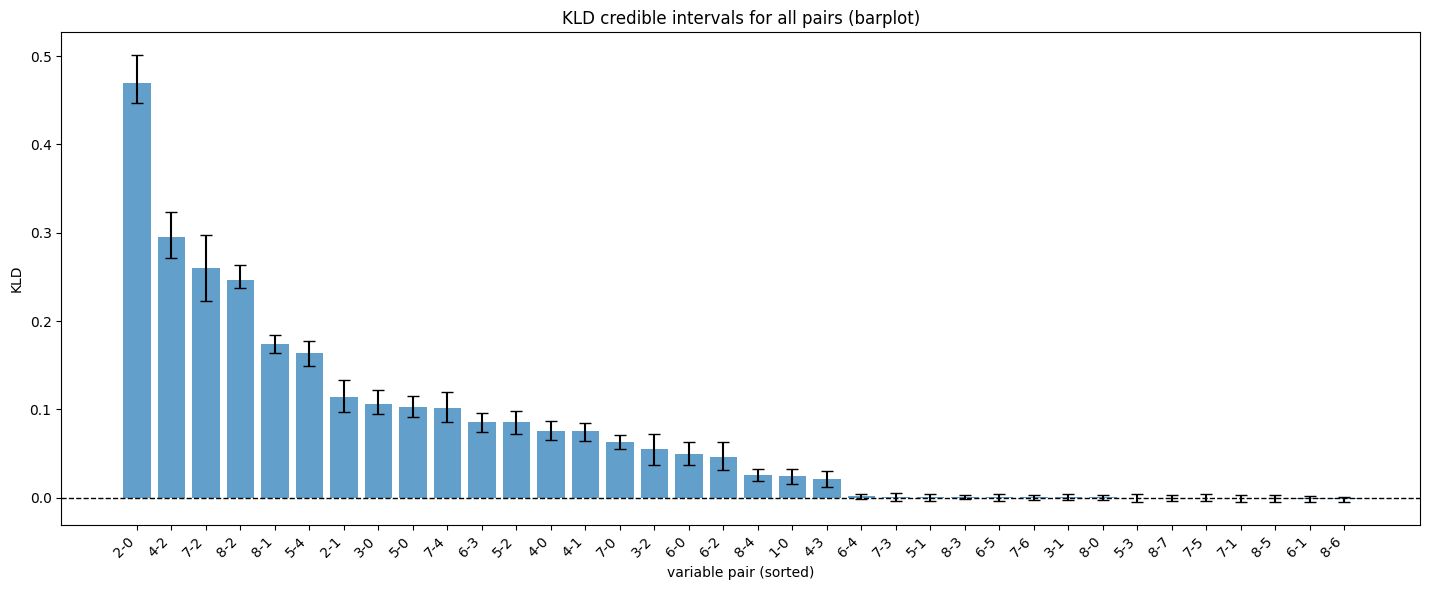

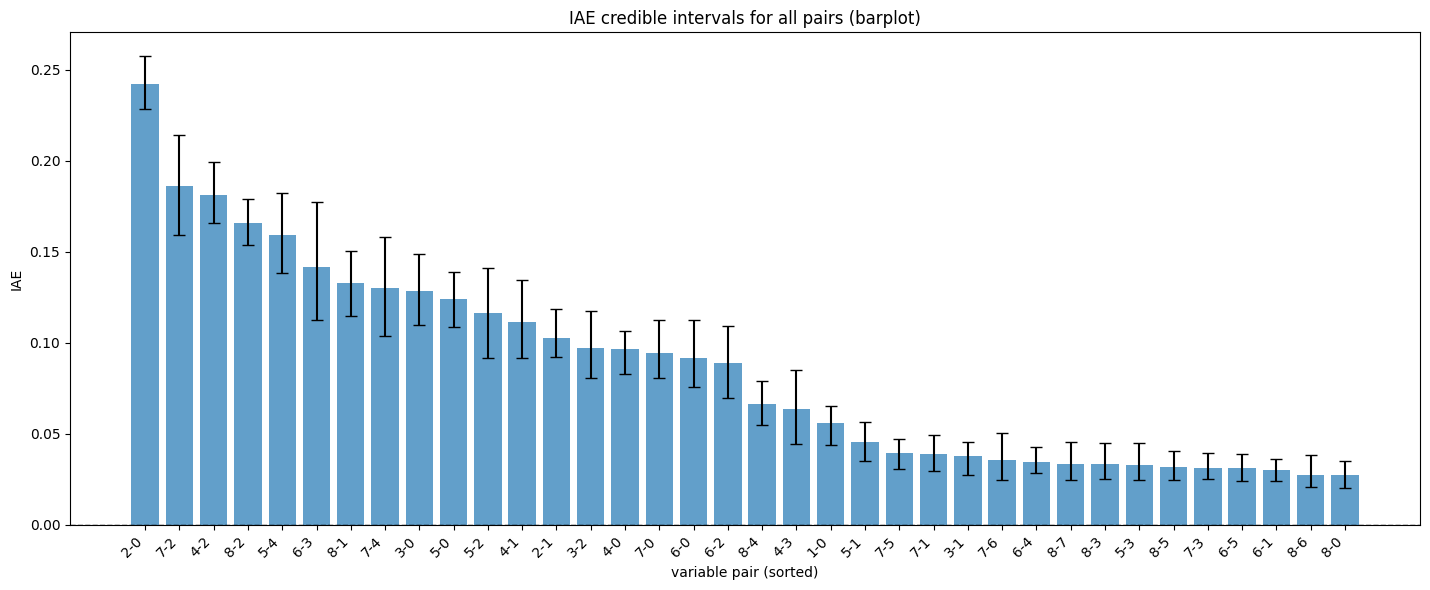

In [26]:
plot_metric_bar_ci(df_ci, metric="kld", log_scale=False)
plot_metric_bar_ci(df_ci, metric="iae", log_scale=False)


In [27]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


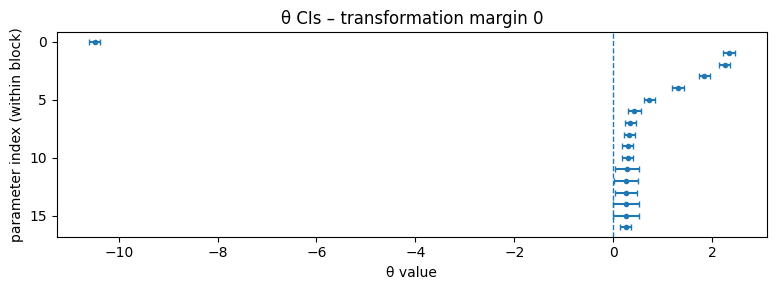

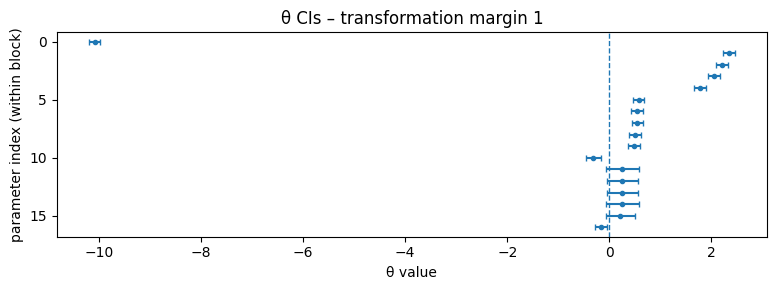

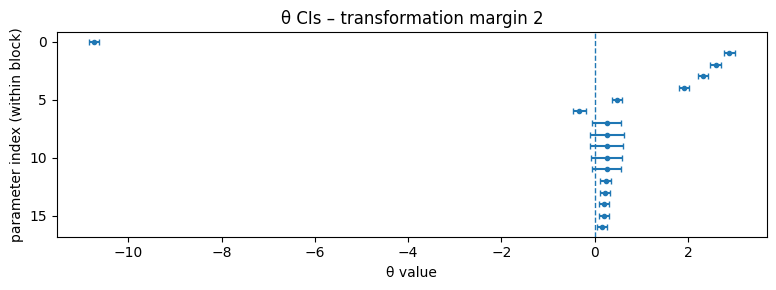

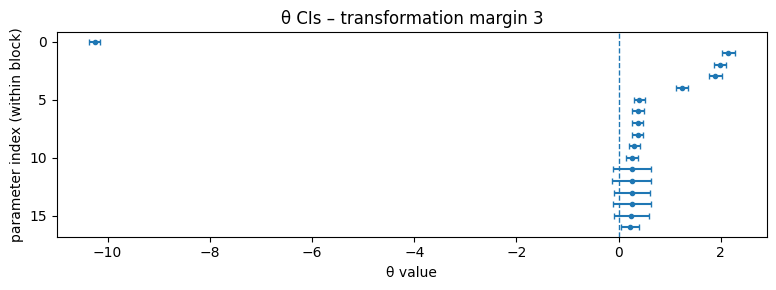

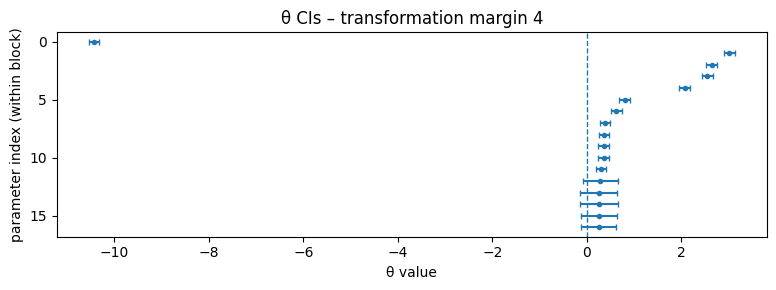

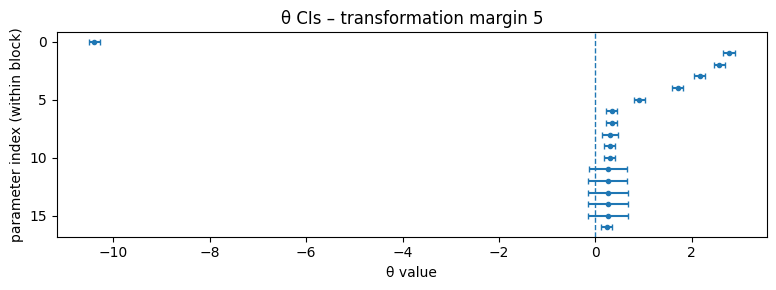

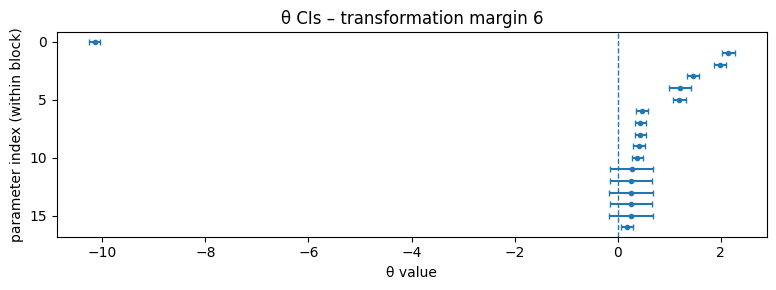

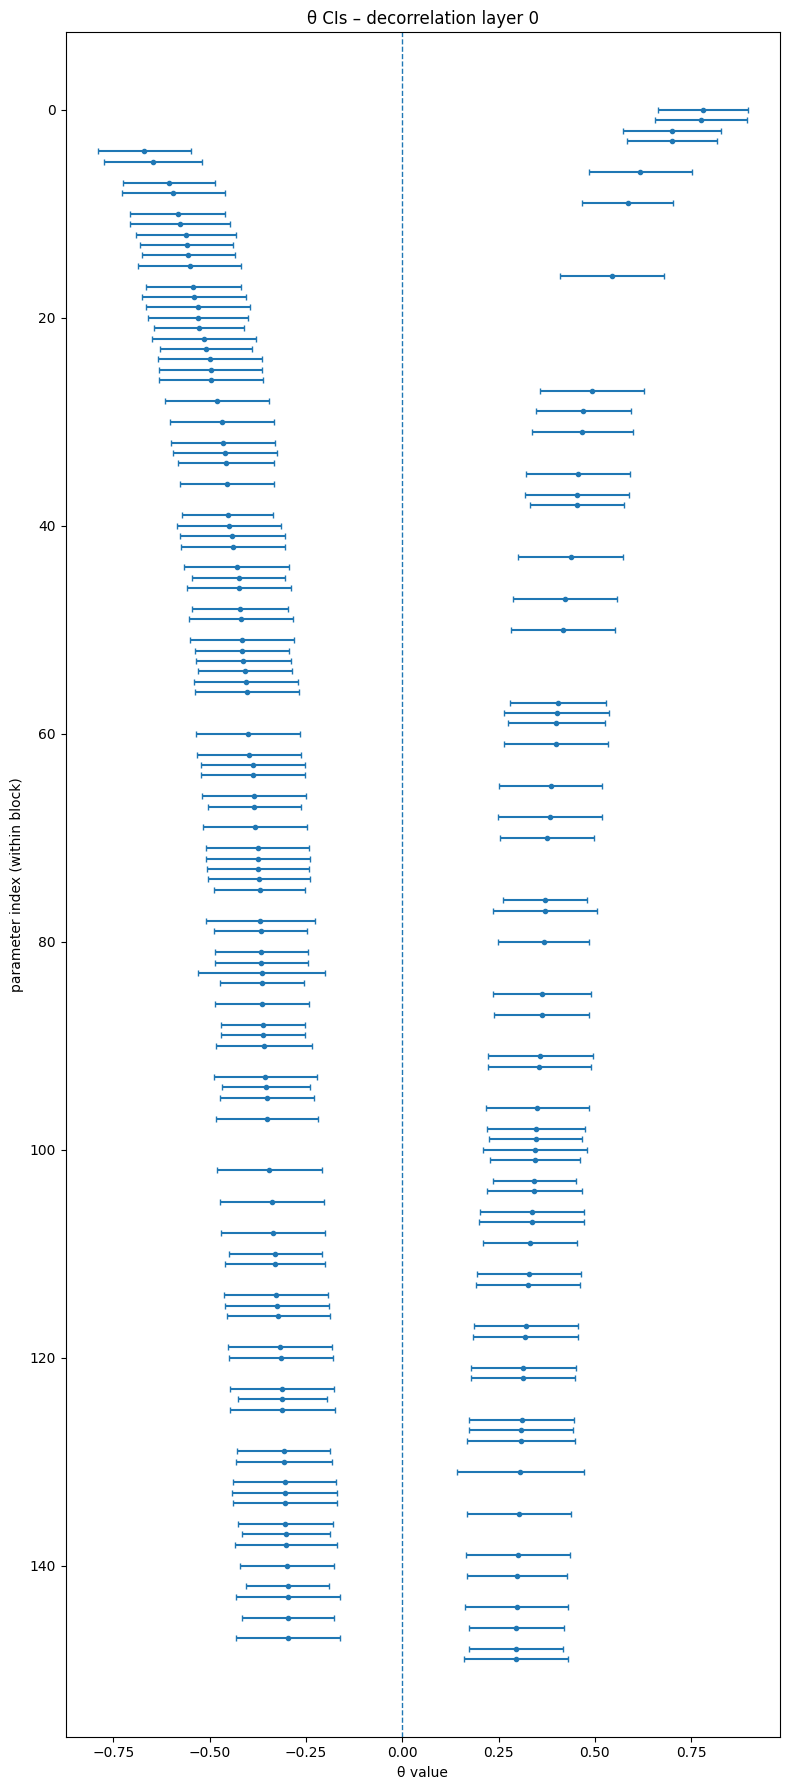

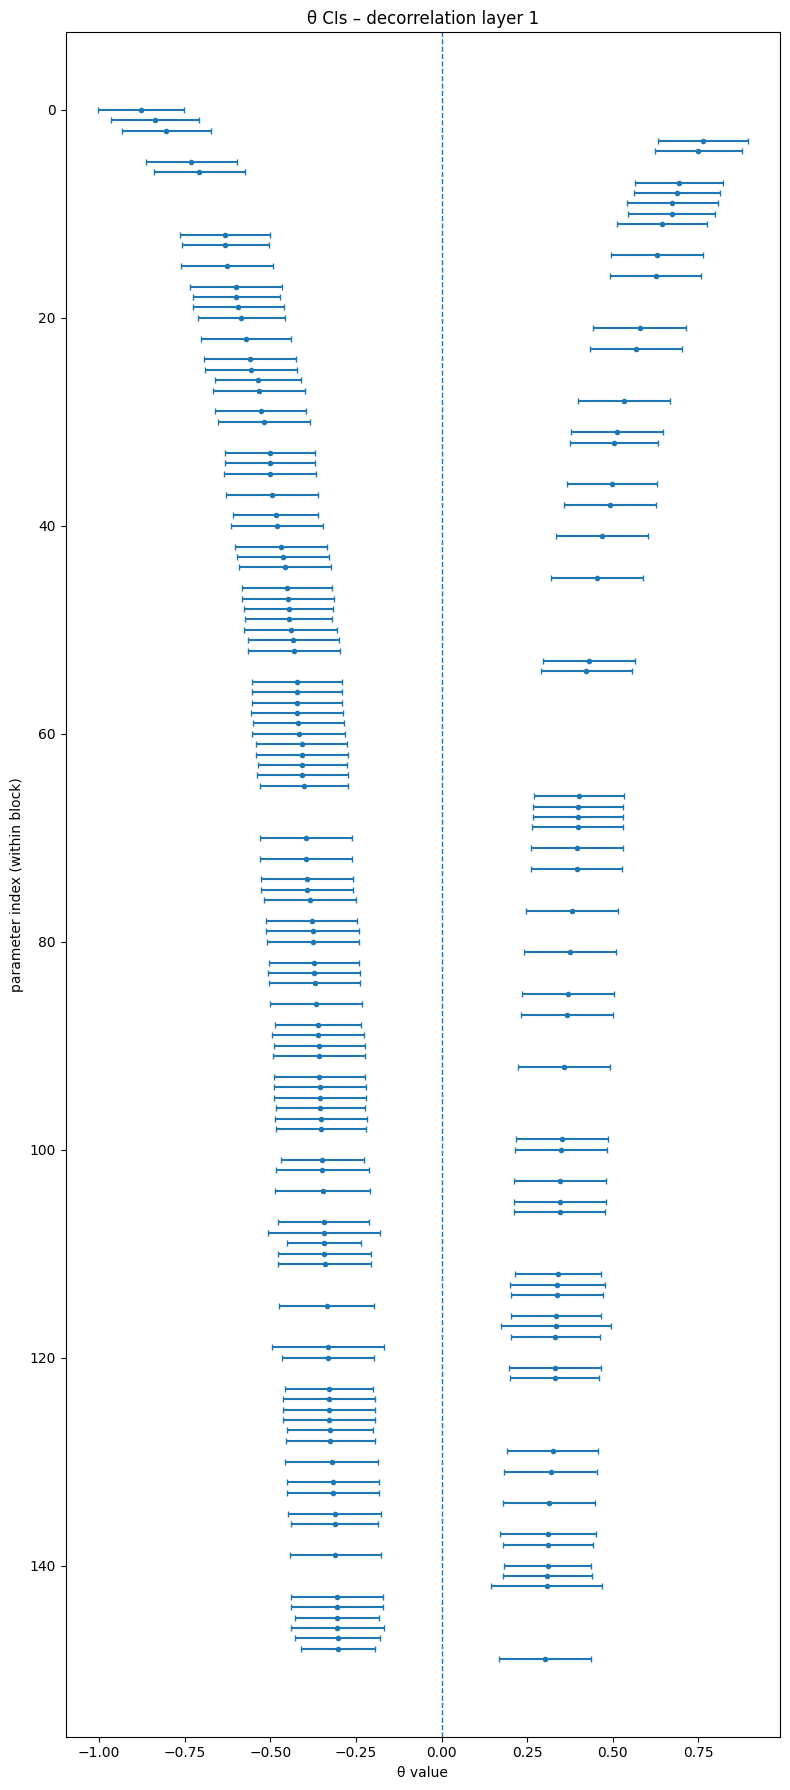

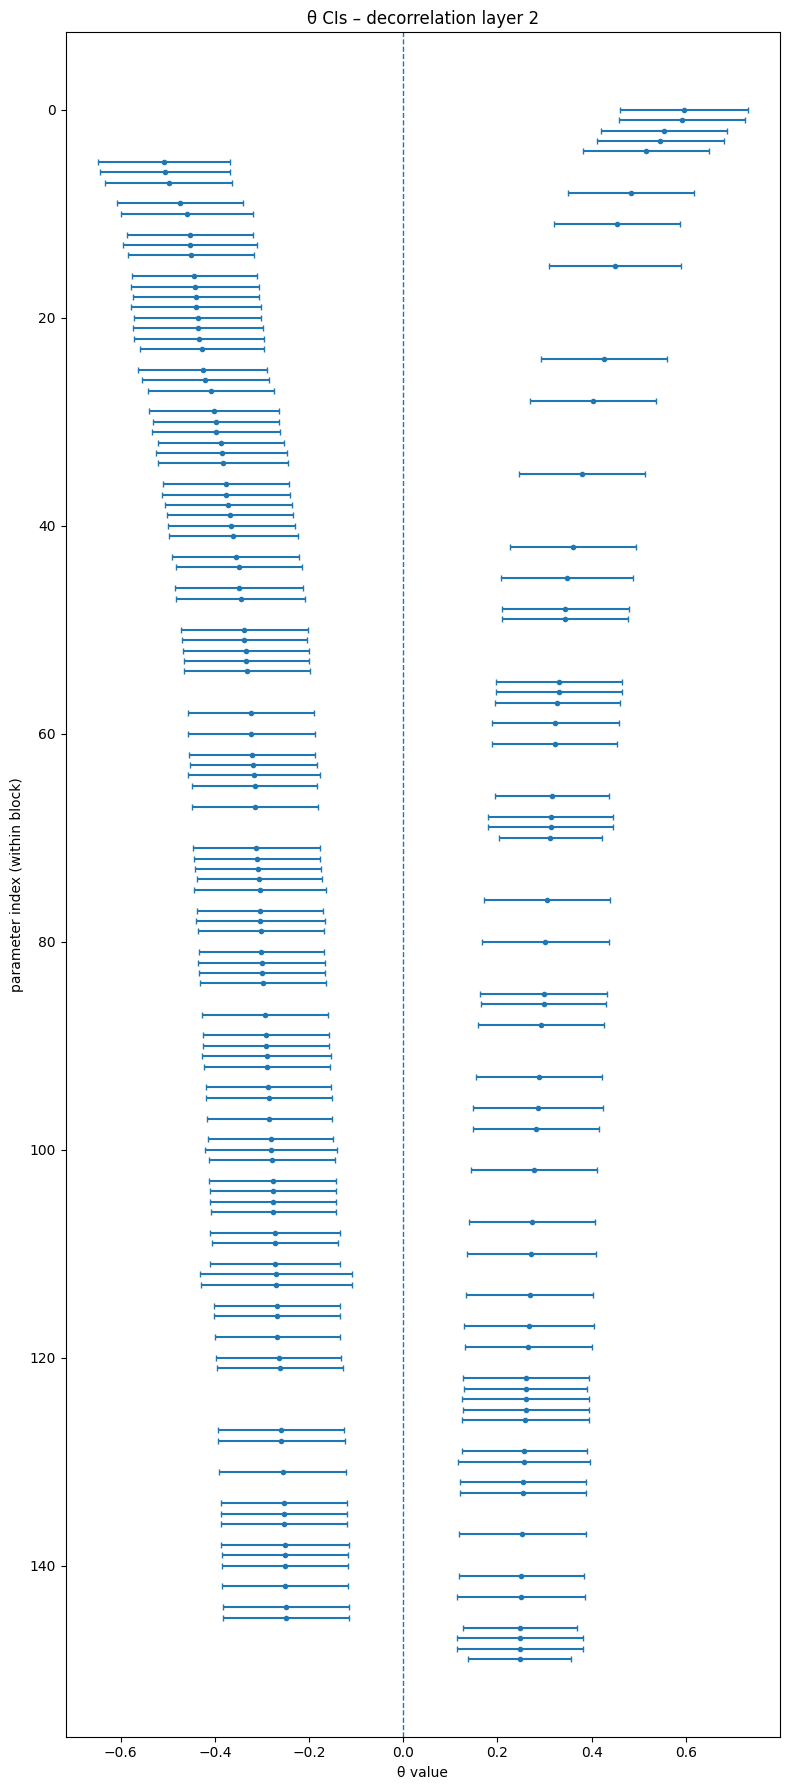

In [28]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


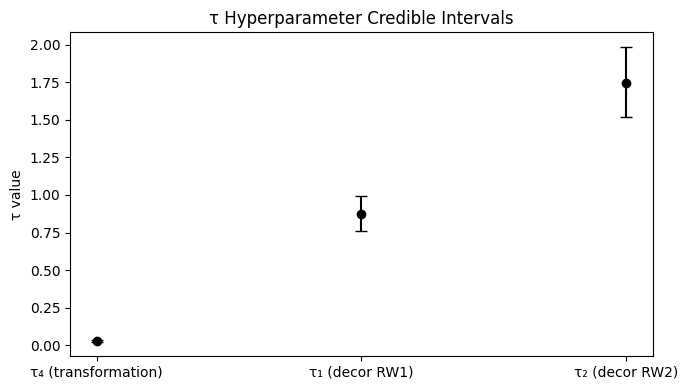

In [29]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [30]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]
[FIX] var 8: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


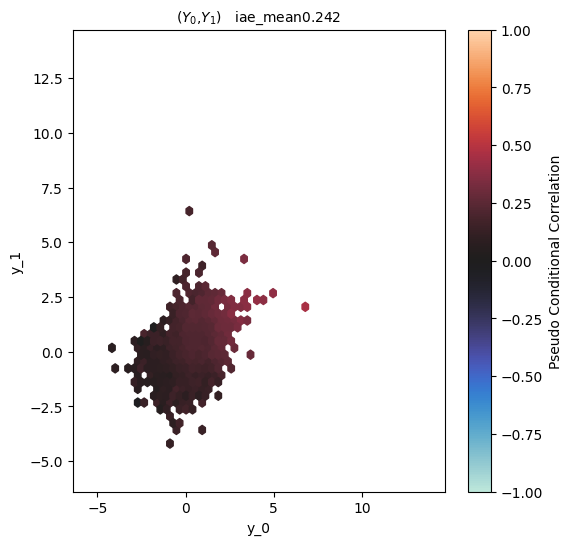

In [31]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

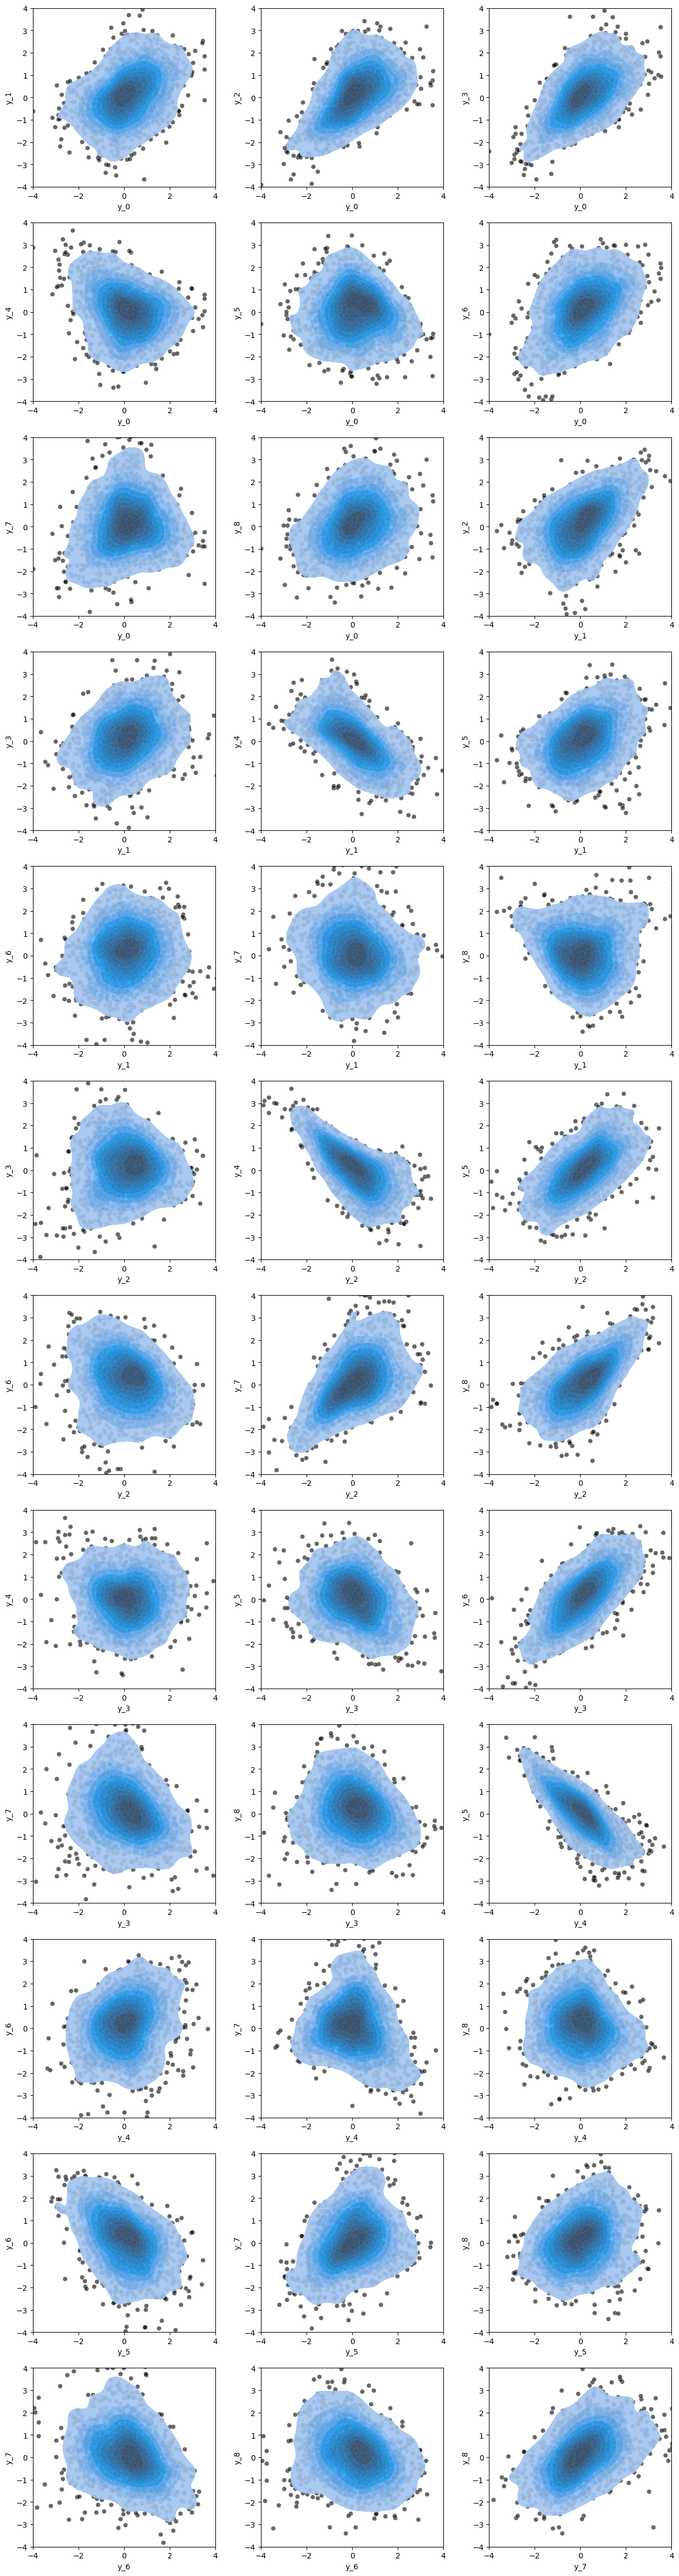

In [32]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [33]:
#model.plot_splines(layer_type="transformation")

In [34]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [35]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [36]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [37]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [38]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [39]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.986394,0.602796,-0.439897,0.029858,-0.497297,0.238353,0.138739,0.117632,0.107593,...,-0.342600,-0.309653,-0.349292,-0.398970,-0.344402,-0.435006,-0.379923,-0.407465,-0.366281,-0.338985
var_row,0.986394,1.000000,0.469444,-0.398080,0.032227,-0.459012,0.246729,0.140261,0.118341,0.106990,...,-0.293178,-0.262516,-0.302311,-0.356459,-0.302833,-0.400298,-0.346804,-0.365592,-0.337540,-0.324416
var_col,0.602796,0.469444,1.000000,-0.399124,0.039795,-0.436832,0.103467,0.097465,0.089898,0.091333,...,-0.389078,-0.347456,-0.375639,-0.378509,-0.367419,-0.357111,-0.321883,-0.367810,-0.296179,-0.214444
abs_mean,-0.439897,-0.398080,-0.399124,1.000000,-0.184299,0.888288,-0.334620,-0.235521,-0.227542,-0.218533,...,0.950579,0.930245,0.949550,0.909910,0.902960,0.896010,0.927671,0.914801,0.925097,0.756615
mean,0.029858,0.032227,0.039795,-0.184299,1.000000,-0.163964,0.894466,0.952896,0.964736,0.975290,...,-0.157014,-0.180695,-0.166023,-0.182754,-0.204118,-0.168082,-0.168597,-0.141828,-0.165251,-0.306442
std,-0.497297,-0.459012,-0.436832,0.888288,-0.163964,1.000000,-0.418790,-0.310682,-0.278764,-0.257915,...,0.851995,0.786873,0.839640,0.865380,0.845302,0.882111,0.897040,0.897812,0.877735,0.762038
min,0.238353,0.246729,0.103467,-0.334620,0.894466,-0.418790,1.000000,0.971171,0.954183,0.944916,...,-0.267181,-0.247876,-0.271815,-0.344916,-0.333333,-0.352896,-0.346976,-0.328958,-0.330245,-0.442036
q_1,0.138739,0.140261,0.097465,-0.235521,0.952896,-0.310682,0.971171,1.000000,0.994595,0.989447,...,-0.192021,-0.180695,-0.193308,-0.244015,-0.246075,-0.240669,-0.243501,-0.222651,-0.230116,-0.349833
q_5,0.117632,0.118341,0.089898,-0.227542,0.964736,-0.278764,0.954183,0.994595,1.000000,0.996654,...,-0.191506,-0.181467,-0.194595,-0.227542,-0.231918,-0.222909,-0.229858,-0.205920,-0.220077,-0.322714
q_10,0.107593,0.106990,0.091333,-0.218533,0.975290,-0.257915,0.944916,0.989447,0.996654,1.000000,...,-0.185071,-0.180695,-0.187645,-0.221622,-0.229344,-0.209524,-0.213385,-0.190219,-0.204891,-0.322714


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [40]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.9015873015873016
AUC KLD                    : 0.9047619047619048
AUC Conditional Correlation: 0.873015873015873
AUC Precision Matrix       : 0.9428571428571428


We further print the ROC Curves for different metrics.

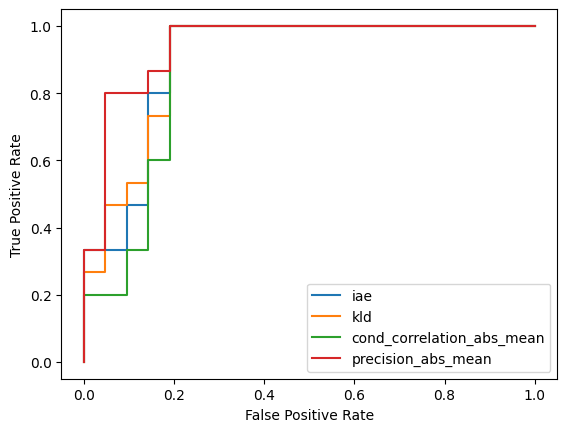

In [41]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()